# Authors 
ID: 0001187926  Name: Cono Cirone         Email: cono.cirone@studio.unibo.it \
ID: 0001169321  Name: Jacopo Dardini      Email: jacopo.dardini@studio.unibo.it \
ID: 0001189948  Name: Giulio Petrozziello Email: giulio.petrozziello@studio.unibo.it

In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

In [ ]:
!pip install torchinfo 

In [ ]:
!pip install torchview

In [58]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import torch
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from torchvision.transforms import RandAugment
import torch.nn.functional as F
from torch import nn
import torchvision
from torchinfo import summary
from torchvision.transforms import v2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchview import draw_graph
from collections import Counter
from sklearn.metrics import classification_report
import random
import json
import os
import math
from sklearn.metrics import confusion_matrix

In [59]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [ ]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f'Device: {device}')

Total images: 3669
Number of classes: 37


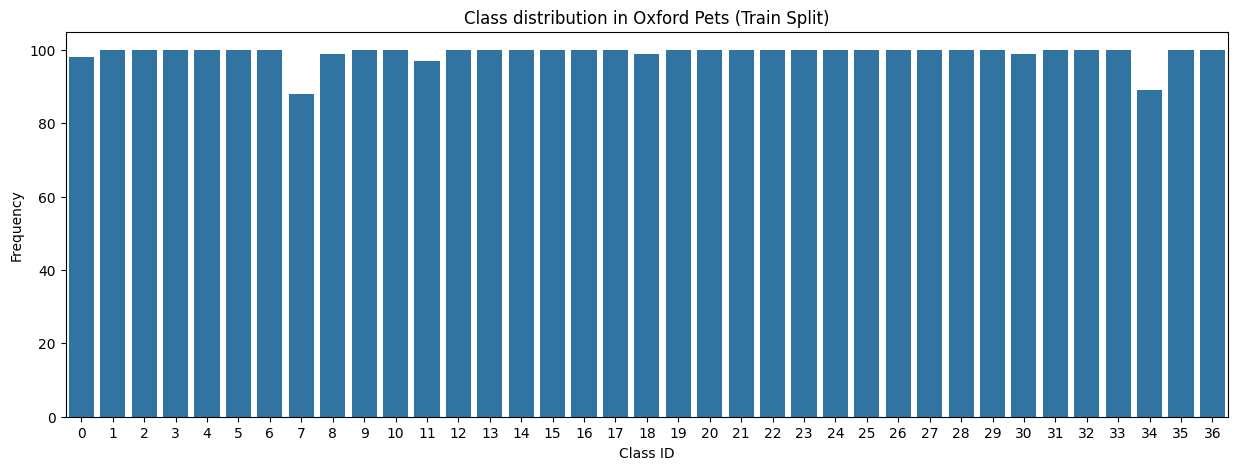

In [61]:
dataset = OxfordPetDataset("train")  # example split
labels = dataset.labels

print(f"Total images: {len(dataset)}")
print(f"Number of classes: {dataset.get_num_classes()}")

# Class distribution
counts = Counter(labels)
plt.figure(figsize=(15,5))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.title("Class distribution in Oxford Pets (Train Split)")
plt.show()

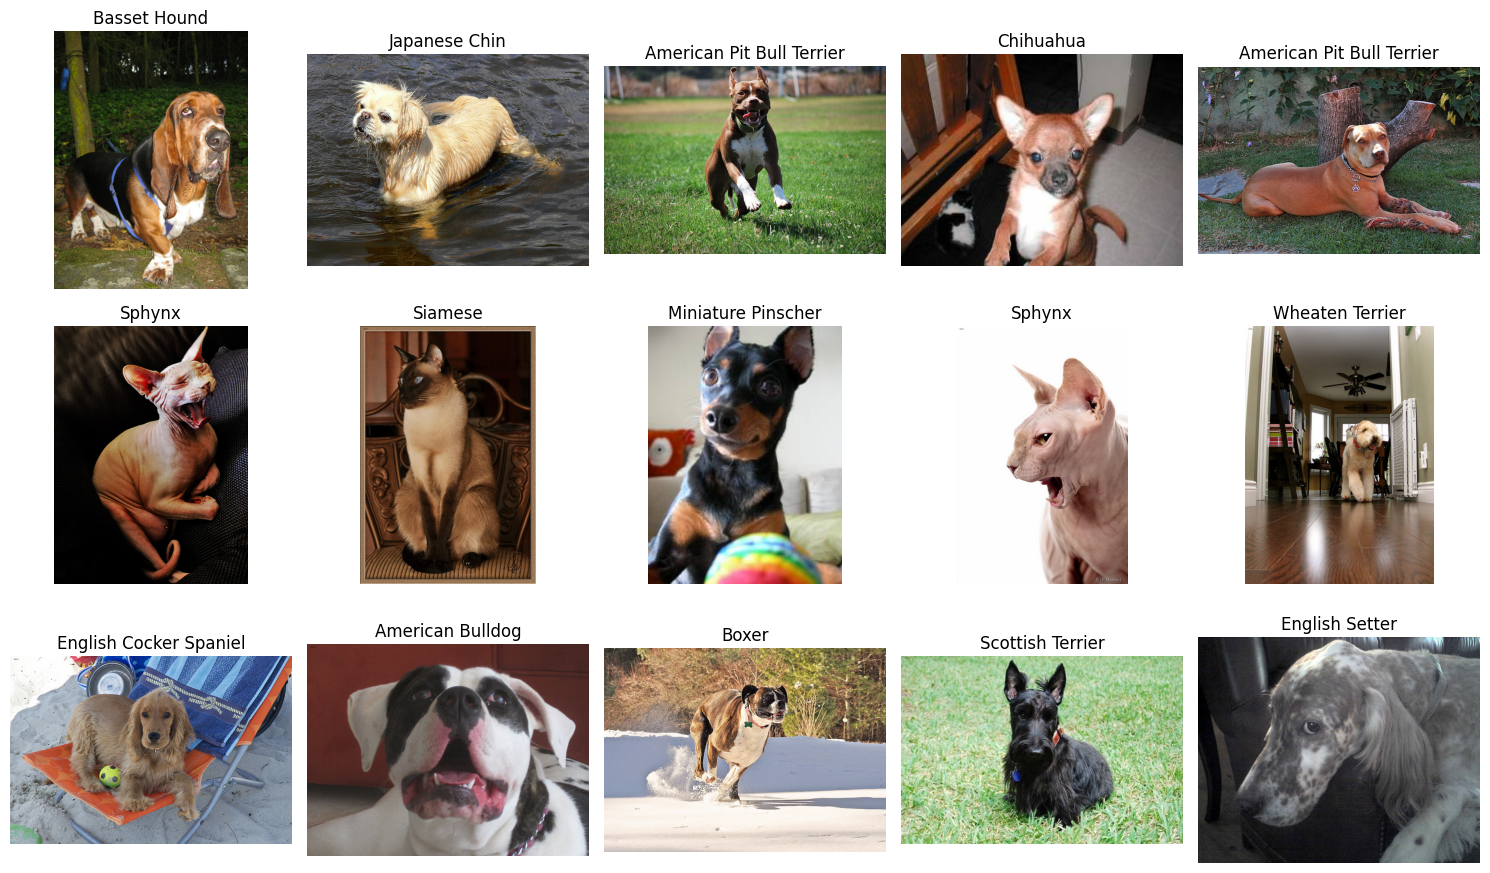

In [32]:
def build_class_names(ds):
    class_names = [""] * ds.get_num_classes()
    for name, label in zip(ds.names, ds.labels):
        cname = "_".join(name.split("_")[:-1])  # drop trailing index
        if not class_names[label]:
            class_names[label] = cname
    return class_names

class_names = build_class_names(dataset)

# Visualization with names
fig, axes = plt.subplots(3, 5, figsize=(15,9))
for ax in axes.flatten():
    idx = random.randrange(len(dataset))
    img, label = dataset[idx]

    if isinstance(img, torch.Tensor):      # tensor (C,H,W) -> (H,W,C)
        img = img.permute(1,2,0).numpy()
    else:                                  # PIL Image
        img = np.array(img)

    ax.imshow(img)
    ax.set_title(class_names[label].replace("_"," ").title())
    ax.axis("off")

plt.tight_layout()
plt.show()

### Data Augmentation

The Oxford-IIIT Pet Dataset contains ~7,390 images across 37 breeds, with only ~200 samples per class. This limited size makes models prone to overfitting, while high intra-class variability (pose, scale, lighting, background, appearance) and strong inter-class similarity (breeds with subtle differences) add further complexity.  

To address these issues, we use an augmentation pipeline combining geometric transforms (crop, flip, rotation, affine) to mimic pose and scale variations, photometric transforms (color jitter, grayscale, RandAugment) to handle lighting and color shifts, and robustness techniques (random erasing, CutMix/MixUp) to simulate occlusion and improve generalization.  


In [62]:
#Load datasets -> stats for ImageNet
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]

strong_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.75, 1.33)),  # Crop 60%-100%
    transforms.RandomHorizontalFlip(p=0.5), # horizontal flip 50% prob
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # random variation in brightness, contrast, saturation
    transforms.RandomGrayscale(p=0.1),  # 10% prob in converting the image into grayscale
    transforms.RandomRotation(degrees=15),  # Add rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Translation + scale + rotation
    RandAugment(num_ops=2, magnitude=8),  # Random augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.3), ratio=(0.3, 3.3))  # random erase
])


enhanced_val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

train_dataset = OxfordPetDataset('train', transform=strong_train_transform)
val_dataset = OxfordPetDataset('val',transform=enhanced_val_transform)
test_dataset = OxfordPetDataset('test', transform=enhanced_val_transform)

In [63]:
batch_size = 64
num_epochs = 150

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def train_with_validation(model, model_name, train_loader, val_loader, num_epochs, base_path, num_classes=37):
    """
    Trains and validates a PyTorch model for a specified number of epochs.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        model_name (str): A name for the model, used for saving the checkpoint.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        num_epochs (int): The total number of epochs to train for.
        base_path (str): The directory path where the model checkpoint will be saved.
        num_classes (int, optional): The number of classes in the dataset. Defaults to 37.

    Returns:
        dict: A dictionary containing the history of training and validation metrics,
              including accuracies, losses, and learning rates.
    """
    # Set the device to CUDA if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the Adam optimizer with weight decay for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Configure the OneCycleLR scheduler.
    # This scheduler warms up the learning rate, then anneals it down.
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,          # Percentage of epochs for the warmup phase
        div_factor=25,          # Initial LR is max_lr / div_factor
        final_div_factor=1000   # Final LR is max_lr / final_div_factor
    )

    # CrossEntropyLoss with label smoothing as loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # A random choice is made for each batch to either apply CutMix, MixUp, or no augmentation.
    cutmix = v2.CutMix(num_classes=num_classes)
    mixup = v2.MixUp(num_classes=num_classes)
    identity = v2.Identity()
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])

    # Initialize tracker for the best validation accuracy
    best_val_acc = 0.0

    # Dictionary to store metrics for plotting 
    history = {"train_acc": [], "val_acc": [], "lrs": [], "train_loss": [], "val_loss": []}

    # --- Main Training Loop ---
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        # Iterate over batches from the training data loader
        for inputs, targets in train_loader:
            # Move data to the selected device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Apply CutMix or MixUp augmentation
            inputs, targets = cutmix_or_mixup((inputs, targets))

            # Zero the gradients before the backward pass
            optimizer.zero_grad()
            
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            
            # Calculate the batch loss
            loss = criterion(outputs, targets)
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Perform a single optimization step (parameter update)
            optimizer.step()
            
            # Update the learning rate
            scheduler.step()

            # Store the current learning rate for this batch
            history["lrs"].append(scheduler.get_last_lr()[0])

            # --- Training Statistics ---
            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            
            # Handle soft labels from augmentations (CutMix/MixUp)
            if targets.ndim == 2:
                targets_labels = targets.argmax(1)
            else:
                targets_labels = targets
            
            train_correct += (preds == targets_labels).sum().item()
            total_train += targets.size(0)

        # --- Validation Phase ---
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        # Disable gradient calculations for validation to save memory and computations
        with torch.no_grad():
            # Iterate over batches from the validation data loader
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # --- Accumulate Validation Statistics ---
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == targets).sum().item()
                total_val += targets.size(0)

        # --- Calculate and Log Epoch Metrics ---
        avg_train_loss = train_loss / total_train
        avg_val_loss = val_loss / total_val
        train_acc = 100. * train_correct / total_train
        val_acc = 100. * val_correct / total_val

        # Store the metrics for the current epoch
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        # Save the model checkpoint if it has the best validation accuracy so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{base_path}{model_name}.pth")

        # Print a summary of the epoch's performance
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | '
              f'Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}% | '
              f'LR={scheduler.get_last_lr()[0]:.6f}')
    return history

In [ ]:
def evaluate_accuracy(model, model_name, test_loader, base_path, history):
    """
    Evaluates the model's accuracy on the test dataset.

    Args:
        model (torch.nn.Module): The PyTorch model to be evaluated.
        model_name (str): The name of the model, used to load the correct checkpoint file.
        test_loader (DataLoader): DataLoader for the test dataset.
        base_path (str): The directory path where the model checkpoint is saved.
        history (dict): A dictionary to store the evaluation results (test accuracy and std).
    """
    # Set the model to evaluation mode 
    model.eval()
    model.to(device)
    
    # Load the weights of the best model saved during training
    model.load_state_dict(torch.load(f"{base_path}{model_name}.pth"))

    # Initialize counters for accuracy calculation
    correct = 0
    total = 0
    batch_accuracies = []

    # Disable gradient calculations 
    with torch.no_grad():
        # Iterate over all batches in the test loader
        for inputs, targets in test_loader:
            # Move data to the selected device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Perform a forward pass to get model predictions
            outputs = model(inputs)
            
            # Get the index of the max logit as the predicted label
            pred = outputs.argmax(1)
            
            # Calculate the number of correct predictions in the current batch
            batch_correct = (pred == targets).sum().item()
            
            # Store the accuracy of the current batch for standard deviation calculation
            batch_accuracies.append(100. * batch_correct / targets.size(0))
            
            # Accumulate total correct predictions and total samples
            correct += batch_correct
            total += targets.size(0)

    # Calculate the overall accuracy on the entire test set
    accuracy = 100. * correct / total
    
    # Calculate the standard deviation of batch accuracies
    accuracy_std = np.std(batch_accuracies)
    
    print(f"Accuracy on test set: {accuracy}")

    # Store the final accuracy and its standard deviation in the history dictionary
    history['test_acc'] = accuracy
    history['test_acc_std'] = accuracy_std


In [ ]:
def evaluate_per_class(model, model_name, loader, dataset: OxfordPetDataset, base_path, history):
    """
    Evaluates the model's performance on a per-class basis using a classification report.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        model_name (str): The name of the model, used to load the correct checkpoint.
        loader (DataLoader): The DataLoader for the dataset to evaluate (e.g., test set).
        dataset (OxfordPetDataset): The dataset object, used to map class labels to names.
        base_path (str): The directory path where the model checkpoint is saved.
        history (dict): A dictionary to which the calculated metrics (precision, recall, f1-score) will be added.
    """
    # Set the model to evaluation mode
    model.eval()
    model.to(device)
    # Load the weights of the best model saved during training
    model.load_state_dict(torch.load(f"{base_path}{model_name}.pth"))

    # Initialize lists to store all ground truth labels and model predictions
    all_labels, all_preds = [], []

    # Create a mapping from class index to class name for the classification report
    label_to_name = {label: "_".join(name.split("_")[:-1]) for name, label in zip(dataset.names, dataset.labels)}
    class_names = [label_to_name[i] for i in range(dataset.get_num_classes())]

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Iterate over the data loader to get predictions for the entire dataset
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass to get model outputs
            outputs = model(images)
            # Get the predicted class index by finding the max logit
            _, preds = torch.max(outputs, 1)
            # Collect the labels and predictions from the current batch
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Generate a classification 
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)

    # Extract the macro-averaged metrics 
    macro_avg = report['macro avg']

    # Store the macro-averaged precision, recall, and F1-score in the history dictionary
    history['precision'] = macro_avg['precision']
    history['recall'] = macro_avg['recall']
    history['f1-score'] = macro_avg['f1-score']

In [ ]:
# --- Environment Setup ---

in_colab=False
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = "/content/drive/MyDrive/models/"
    os.makedirs(base_path, exist_ok=True)
else:
    base_path = "./models/"
    os.makedirs(base_path, exist_ok=True)

with open(f"{base_path}results.json", "w") as f:
    f.write("{}")

## Part 1A: Baseline Model – MobileNet

We implement a **modified version of MobileNetV2** (link: https://arxiv.org/pdf/1801.04381), built from **inverted residual blocks** (expansion → depthwise convolution → projection). 
We chose this architecture for its lightweight design, making it well-suited for training on resource-constrained hardware without powerful GPUs. We experimented with various MobileNet configurations, systematically tuning the network architecture until we identified the optimal setup that delivered the best performance on our dataset.

### Base Model Hyperparameters

**Optimizer**: Adam
- Learning rate: `1e-3`
- Weight decay: `1e-4`

**Scheduler**: OneCycleLR
- Max learning rate: `1e-3`
- Percentage start: `0.3` (30% of epochs for warmup phase)
- Division factor: `25` (initial LR = max_lr / 25)
- Final division factor: `1000` (final LR = max_lr / 1000)

**Loss**: CrossEntropyLoss
- Label smoothing: `0.1`

This baseline MobileNet is our **best performing model** and serves as the **reference point** for the subsequent ablation study.  In the following sections, we will show how different architectural and hyperparameter choices impact the model's performance.

In [12]:
class InvertedResidualBlock(nn.Module):
    """
     MobileNetV2 Block: Expand -> Depthwise -> Project [+ Residual if possible]
    """
    def __init__(self, in_channels, out_channels, stride=1, expansion=6):
        super(InvertedResidualBlock, self).__init__()
        hidden_dim = in_channels * expansion
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []

        # 1. Expansion (pointwise conv)
        if expansion != 1:
            layers += [
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ]

        # 2. Depthwise + 3. Pointwise projection
        layers += [
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False), # groups -> each input channel is convolved independently
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        ]

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

In [68]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=37):
        super(MobileNet, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvertedResidualBlock(32, 64, 1, 1),
            InvertedResidualBlock(64, 64, 2, 6),
            InvertedResidualBlock(64, 64, 1, 6),

            InvertedResidualBlock(64, 128, 2, 6),
            InvertedResidualBlock(128, 128, 1, 6),
            InvertedResidualBlock(128, 128, 1, 6),

            InvertedResidualBlock(128, 256, 2, 6),
            InvertedResidualBlock(256, 256, 1, 6),
            InvertedResidualBlock(256, 256, 1, 6),
            InvertedResidualBlock(256, 256, 1, 6),

            InvertedResidualBlock(256, 512, 2, 6),
            InvertedResidualBlock(512, 512, 1, 6),
            InvertedResidualBlock(512, 512, 1, 6),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        return x

model = MobileNet(num_classes=37).to(device)
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNet                                [1, 37]                   --
├─Sequential: 1-1                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 128, 128]         64
│    └─ReLU6: 2-3                        [1, 32, 128, 128]         --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─InvertedResidualBlock: 2-4        [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         2,528
│    └─InvertedResidualBlock: 2-5        [1, 64, 64, 64]           --
│    │    └─Sequential: 3-2              [1, 64, 64, 64]           54,272
│    └─InvertedResidualBlock: 2-6        [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3              [1, 64, 64, 64]           54,272
│    └─InvertedResidualBlock: 2-7        [1, 128, 32, 32]          --
│  

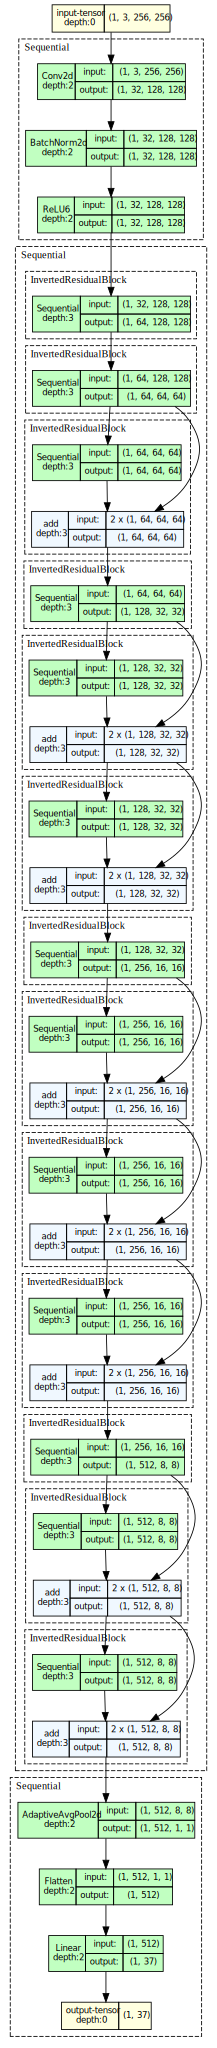

In [12]:
model_graph = draw_graph(model, input_size=(1,3,256,256), expand_nested=True)
model_graph.visual_graph

In [23]:
print("\nFinal Model")
model = MobileNet()
model_name = 'final_model'
history = train_with_validation(model, model_name, train_loader, val_loader, num_epochs=num_epochs, base_path=base_path)
evaluate_accuracy(model, model_name, test_loader, base_path, history)
evaluate_per_class(model, model_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


Final Model
Epoch 1/150: Train Loss=3.6149, Train Acc=4.09% | Val Loss=3.6236, Val Acc=3.22% | LR=0.000041
Epoch 2/150: Train Loss=3.5718, Train Acc=5.01% | Val Loss=3.5713, Val Acc=5.78% | LR=0.000045
Epoch 3/150: Train Loss=3.5514, Train Acc=6.46% | Val Loss=3.5476, Val Acc=5.23% | LR=0.000050
Epoch 4/150: Train Loss=3.5377, Train Acc=6.00% | Val Loss=3.4590, Val Acc=8.62% | LR=0.000059
Epoch 5/150: Train Loss=3.5052, Train Acc=7.55% | Val Loss=3.4644, Val Acc=6.54% | LR=0.000069
Epoch 6/150: Train Loss=3.4756, Train Acc=8.07% | Val Loss=3.5275, Val Acc=8.07% | LR=0.000082
Epoch 7/150: Train Loss=3.4921, Train Acc=7.90% | Val Loss=3.4451, Val Acc=7.47% | LR=0.000096
Epoch 8/150: Train Loss=3.4890, Train Acc=8.69% | Val Loss=3.4009, Val Acc=9.16% | LR=0.000113
Epoch 9/150: Train Loss=3.4858, Train Acc=7.93% | Val Loss=3.3805, Val Acc=10.36% | LR=0.000132
Epoch 10/150: Train Loss=3.4704, Train Acc=8.34% | Val Loss=3.3843, Val Acc=10.03% | LR=0.000152
Epoch 11/150: Train Loss=3.4242, T

In [ ]:
# Run ablation study with different architectures
results = {}
histories = {}
param_counts = {}

## Part 1B: Architecture Ablation Study

### Models Overview
Starting from our baseline MobileNet, we systematically modify the architecture to understand how each design choice affects performance. Each variant removes or alters a specific component:

* **`no_depthwise`**: Replaces **depthwise separable convolutions** with standard convolutions, testing the efficiency/accuracy trade-off.  
* **`no_batchnorm`**: Removes all **Batch Normalization layers**, evaluating how BN contributes to training stability.  
* **`no_expansion`**: Disables the **expansion layers** in inverted residual blocks, reducing intermediate dimensionality.  
* **`reduced_depth`**: Uses fewer residual blocks, producing a shallower network to test the role of depth in generalization.  
* **`reduced_channels`**: Applies a **width multiplier (0.5×)**, scaling down the number of channels to study the size/accuracy trade-off.

### Training Strategy

We train each model for a **fixed number of epochs**, saving a checkpoint whenever it achieves a new best validation accuracy.  
At the end of training, the model used for testing corresponds to this best-performing checkpoint.  

This ensures a consistent experimental setup where only the component under investigation is changed, isolating its impact on performance.


### First Approach: No Depthwise

In this variant, we remove **depthwise separable convolutions** throughout the network.  

Depthwise separable convolutions are one of the key innovations in MobileNet, drastically reducing the number of parameters and computational cost by splitting the operation into:
- a **depthwise convolution** (per-channel filtering), followed by
- a **pointwise convolution** (1×1 projection across channels).

By removing this separation, we create a model that is **computationally heavier** and has **more parameters**, but serves as a baseline to measure how much depthwise separable convolutions actually contribute to efficiency and performance.

However, the resulting model reached **~285M trainable parameters**, making it far too heavy to train within our available computational resources. This highlights the importance of depthwise separable convolutions in enabling MobileNet to remain lightweight and efficient.

In [7]:
# 1. No Depthwise Separable
class InvResNoDepthBlock(nn.Module):
    """
     MobileNetV2 Block: Expand -> Depthwise -> Project [+ Residual if possible]
    """
    def __init__(self, in_channels, out_channels, stride=1, expansion=6):
        super(InvResNoDepthBlock, self).__init__()
        hidden_dim = in_channels * expansion
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []

        # 1. Expansion (pointwise conv)
        if expansion != 1:
            layers += [
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ]

        # 2. Depthwise + 3. Pointwise projection
        layers += [
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        ]

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

class MobileNet_NoDepth(nn.Module):
    """MobileNet with No depthwise separable convs"""
    def __init__(self, num_classes=37, ):
        super(MobileNet_NoDepth, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvResNoDepthBlock(32, 64, 1),
            InvResNoDepthBlock(64, 64, 2),
            InvResNoDepthBlock(64, 64, 1),
            InvResNoDepthBlock(64, 128, 2),
            InvResNoDepthBlock(128, 128, 1),
            InvResNoDepthBlock(128, 128, 1),
            InvResNoDepthBlock(128, 256, 2),
            InvResNoDepthBlock(256, 256, 1),
            InvResNoDepthBlock(256, 256, 1),
            InvResNoDepthBlock(256, 256, 1),
            InvResNoDepthBlock(256, 512, 2),
            InvResNoDepthBlock(512, 512, 1),
            InvResNoDepthBlock(512, 512, 1),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        return x

model = MobileNet_NoDepth(num_classes=37).to(device)
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNet_NoDepth                        [1, 37]                   --
├─Sequential: 1-1                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 128, 128]         64
│    └─ReLU6: 2-3                        [1, 32, 128, 128]         --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─InvResNoDepthBlock: 2-4           [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         351,104
│    └─InvResNoDepthBlock: 2-5           [1, 64, 64, 64]           --
│    │    └─Sequential: 3-2              [1, 64, 64, 64]           1,377,920
│    └─InvResNoDepthBlock: 2-6           [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3              [1, 64, 64, 64]           1,377,920
│    └─InvResNoDepthBlock: 2-7           [1, 128, 32, 32]        

In [ ]:
# No Depthwise Separable
model2 = MobileNet_NoDepth()
model2_name='no_depthwise'
history = train_with_validation(model2, model2_name, train_loader, val_loader, num_epochs=num_epochs, base_path=base_path)
evaluate_accuracy(model2, model2_name, test_loader, base_path, history)
evaluate_per_class(model2, model2_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model2_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)

### Second Approach: No Batch Normalization

In this variant, we remove all **Batch Normalization (BN)** layers from the network.  

BatchNorm plays a crucial role in stabilizing training by normalizing activations, reducing internal covariate shift, and allowing for higher learning rates.  
Lightweight models such as MobileNet rely heavily on BN to maintain stable gradients and effective feature learning.

Without BatchNorm, the model completely fails to converge:  
- Training and validation loss remain high.  
- Accuracy stagnates at **~3%**, equivalent to random guessing across the 37 classes.  

This experiment demonstrates that **Batch Normalization is indispensable** for MobileNet training, as its removal prevents the network from learning meaningful representations altogether.


In [4]:
# 3. No Batch Normalization
class InvertedResidualBlock_NoBN(nn.Module):
    """Inverted Residual Block WITHOUT Batch Normalization"""
    def __init__(self, in_channels, out_channels, stride=1, expansion=6):
        super(InvertedResidualBlock_NoBN, self).__init__()
        hidden_dim = in_channels * expansion
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expansion != 1:
            layers += [
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=True),
                nn.ReLU6(inplace=True),
            ]

        layers += [
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=True),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=True),
        ]

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

class MobileNet_NoBN(nn.Module):
    """MobileNet WITHOUT Batch Normalization"""
    def __init__(self, num_classes=37, ):
        super(MobileNet_NoBN, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvertedResidualBlock_NoBN(32, 64, 1, 1),
            InvertedResidualBlock_NoBN(64, 64, 2, 6),
            InvertedResidualBlock_NoBN(64, 64, 1, 6),
            InvertedResidualBlock_NoBN(64, 128, 2, 6),
            InvertedResidualBlock_NoBN(128, 128, 1, 6),
            InvertedResidualBlock_NoBN(128, 128, 1, 6),
            InvertedResidualBlock_NoBN(128, 256, 2, 6),
            InvertedResidualBlock_NoBN(256, 256, 1, 6),
            InvertedResidualBlock_NoBN(256, 256, 1, 6),
            InvertedResidualBlock_NoBN(256, 256, 1, 6),
            InvertedResidualBlock_NoBN(256, 512, 2, 6),
            InvertedResidualBlock_NoBN(512, 512, 1, 6),
            InvertedResidualBlock_NoBN(512, 512, 1, 6),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        return x

model = MobileNet_NoBN(num_classes=37).to(device)
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNet_NoBN                                [1, 37]                   --
├─Sequential: 1-1                             [1, 32, 128, 128]         --
│    └─Conv2d: 2-1                            [1, 32, 128, 128]         896
│    └─ReLU6: 2-2                             [1, 32, 128, 128]         --
├─Sequential: 1-2                             [1, 512, 8, 8]            --
│    └─InvertedResidualBlock_NoBN: 2-3        [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1                   [1, 64, 128, 128]         2,432
│    └─InvertedResidualBlock_NoBN: 2-4        [1, 64, 64, 64]           --
│    │    └─Sequential: 3-2                   [1, 64, 64, 64]           53,440
│    └─InvertedResidualBlock_NoBN: 2-5        [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3                   [1, 64, 64, 64]           53,440
│    └─InvertedResidualBlock_NoBN: 2-6        [1, 128, 32, 32]          --
│    │  

In [ ]:
# No Batch Norm
print("\nMobileNet with No Batch Normalization")
model3 = MobileNet_NoBN()
model3_name = 'no_batchnorm'
history = train_with_validation(model3, model3_name, train_loader, val_loader, num_epochs=num_epochs, base_path=base_path)
evaluate_accuracy(model3, model3_name, test_loader, base_path, history)
evaluate_per_class(model3, model3_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model3_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


MobileNet with No Batch Normalization
Epoch 1/150: Train Loss=3.6277, Train Acc=2.18% | Val Loss=3.6154, Val Acc=2.73% | LR=0.000041
Epoch 2/150: Train Loss=3.6222, Train Acc=1.96% | Val Loss=3.6160, Val Acc=2.73% | LR=0.000045
Epoch 3/150: Train Loss=3.6235, Train Acc=2.51% | Val Loss=3.6222, Val Acc=2.51% | LR=0.000050
Epoch 4/150: Train Loss=3.6294, Train Acc=2.29% | Val Loss=3.6210, Val Acc=2.51% | LR=0.000059
Epoch 5/150: Train Loss=3.6263, Train Acc=2.37% | Val Loss=3.6224, Val Acc=2.51% | LR=0.000069
Epoch 6/150: Train Loss=3.6266, Train Acc=2.51% | Val Loss=3.6281, Val Acc=2.73% | LR=0.000082
Epoch 7/150: Train Loss=3.6329, Train Acc=2.21% | Val Loss=3.6247, Val Acc=2.73% | LR=0.000096
Epoch 8/150: Train Loss=3.6334, Train Acc=2.53% | Val Loss=3.6320, Val Acc=2.73% | LR=0.000113
Epoch 9/150: Train Loss=3.6350, Train Acc=2.18% | Val Loss=3.6405, Val Acc=2.73% | LR=0.000132
Epoch 10/150: Train Loss=3.6391, Train Acc=2.48% | Val Loss=3.6307, Val Acc=2.73% | LR=0.000152
Epoch 11/1

### Third Approach: No Expansion Layers

In this variant, we remove the **expansion step** from the inverted residual block.  
Normally, MobileNet temporarily expands the number of channels before applying the depthwise convolution, allowing the network to operate in a higher-dimensional feature space and capture richer representations.

By disabling this expansion, the model becomes **simpler and lighter**, but also loses some expressive power.

Results:  
- The model still trains successfully and generalizes reasonably well.  
- It achieves a **69% test accuracy** coupled with greater overfitting relative to the baseline model.  

This shows that while expansion layers improve accuracy by enriching the learned features, they are **not strictly necessary for convergence**. Removing them leads to a noticeable but not catastrophic drop in performance, trading accuracy for reduced complexity.


In [5]:
# 4. No Expansion Layers
class InvertedResidualBlock_NoExpansion(nn.Module):
    """Inverted Residual Block WITHOUT expansion layer"""
    def __init__(self, in_channels, out_channels, stride=1, expansion=1):  # Force expansion=1
        super(InvertedResidualBlock_NoExpansion, self).__init__()
        self.use_res_connect = stride == 1 and in_channels == out_channels

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

class MobileNet_NoExpansion(nn.Module):
    """MobileNet WITHOUT expansion layers"""
    def __init__(self, num_classes=37):
        super(MobileNet_NoExpansion, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvertedResidualBlock_NoExpansion(32, 64, 1),
            InvertedResidualBlock_NoExpansion(64, 64, 2),
            InvertedResidualBlock_NoExpansion(64, 64, 1),
            InvertedResidualBlock_NoExpansion(64, 128, 2),
            InvertedResidualBlock_NoExpansion(128, 128, 1),
            InvertedResidualBlock_NoExpansion(128, 128, 1),
            InvertedResidualBlock_NoExpansion(128, 256, 2),
            InvertedResidualBlock_NoExpansion(256, 256, 1),
            InvertedResidualBlock_NoExpansion(256, 256, 1),
            InvertedResidualBlock_NoExpansion(256, 256, 1),
            InvertedResidualBlock_NoExpansion(256, 512, 2),
            InvertedResidualBlock_NoExpansion(512, 512, 1),
            InvertedResidualBlock_NoExpansion(512, 512, 1),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        return x

model = MobileNet_NoExpansion(num_classes=37).to(device)
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNet_NoExpansion                              [1, 37]                   --
├─Sequential: 1-1                                  [1, 32, 128, 128]         --
│    └─Conv2d: 2-1                                 [1, 32, 128, 128]         864
│    └─BatchNorm2d: 2-2                            [1, 32, 128, 128]         64
│    └─ReLU6: 2-3                                  [1, 32, 128, 128]         --
├─Sequential: 1-2                                  [1, 512, 8, 8]            --
│    └─InvertedResidualBlock_NoExpansion: 2-4      [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1                        [1, 64, 128, 128]         2,528
│    └─InvertedResidualBlock_NoExpansion: 2-5      [1, 64, 64, 64]           --
│    │    └─Sequential: 3-2                        [1, 64, 64, 64]           4,928
│    └─InvertedResidualBlock_NoExpansion: 2-6      [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3 

In [ ]:
# No Expansion Layers
print("\nMobileNet WITHOUT Expansion Layers")
model4 = MobileNet_NoExpansion()
model4_name = 'no_expansion'
history = train_with_validation(model4, model4_name, train_loader, val_loader, num_epochs=num_epochs, base_path=base_path)
evaluate_accuracy(model4, model4_name, test_loader, base_path, history)
evaluate_per_class(model4, model4_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model4_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


MobileNet WITHOUT Expansion Layers
Epoch 1/150: Train Loss=3.6130, Train Acc=3.90% | Val Loss=3.5929, Val Acc=3.93% | LR=0.000041
Epoch 2/150: Train Loss=3.5947, Train Acc=3.65% | Val Loss=3.5654, Val Acc=4.85% | LR=0.000045
Epoch 3/150: Train Loss=3.5930, Train Acc=3.92% | Val Loss=3.5617, Val Acc=5.56% | LR=0.000050
Epoch 4/150: Train Loss=3.5762, Train Acc=5.04% | Val Loss=3.5417, Val Acc=6.49% | LR=0.000059
Epoch 5/150: Train Loss=3.5653, Train Acc=5.40% | Val Loss=3.5107, Val Acc=5.94% | LR=0.000069
Epoch 6/150: Train Loss=3.5467, Train Acc=5.78% | Val Loss=3.5065, Val Acc=6.32% | LR=0.000082
Epoch 7/150: Train Loss=3.5323, Train Acc=5.89% | Val Loss=3.5133, Val Acc=5.13% | LR=0.000096
Epoch 8/150: Train Loss=3.5275, Train Acc=7.06% | Val Loss=3.4823, Val Acc=7.25% | LR=0.000113
Epoch 9/150: Train Loss=3.5189, Train Acc=6.46% | Val Loss=3.4832, Val Acc=7.74% | LR=0.000132
Epoch 10/150: Train Loss=3.5037, Train Acc=6.54% | Val Loss=3.4710, Val Acc=6.65% | LR=0.000152
Epoch 11/150:

### Fourth Approach: Reduced Depth

In this variant, we reduce the overall **number of residual blocks** in the network, creating a shallower MobileNet.  
This decreases the total number of parameters and speeds up training, while still preserving the core inverted residual block structure.

Results:  
- The model trains stably and generalizes well.  
- It achieves a **74% test accuracy**, which is very close to the **76% baseline**.  

This suggests that **depth is not the most critical factor** for MobileNet’s performance on this dataset.  
A slightly shallower network can still achieve nearly the same accuracy, while offering reduced computational cost and faster training.


In [8]:
class MobileNet_ReducedDepth(nn.Module):
    """MobileNet with REDUCED depth (fewer blocks)"""
    def __init__(self, num_classes=37):
        super(MobileNet_ReducedDepth, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # Reduced number of blocks
        self.features = nn.Sequential(
            InvertedResidualBlock(32, 64, 1, 1),
            InvertedResidualBlock(64, 64, 2, 6),
            InvertedResidualBlock(64, 128, 2, 6),
            InvertedResidualBlock(128, 128, 1, 6),
            InvertedResidualBlock(128, 256, 2, 6),
            InvertedResidualBlock(256, 256, 1, 6),
            InvertedResidualBlock(256, 512, 2, 6),
            InvertedResidualBlock(512, 512, 1, 6),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        return x

model = MobileNet_ReducedDepth(num_classes=37).to(device)
summary(model, input_size=(1, 3, 256, 256))


Layer (type:depth-idx)                   Output Shape              Param #
MobileNet_ReducedDepth                   [1, 37]                   --
├─Sequential: 1-1                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 128, 128]         64
│    └─ReLU6: 2-3                        [1, 32, 128, 128]         --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─InvertedResidualBlock: 2-4        [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         2,528
│    └─InvertedResidualBlock: 2-5        [1, 64, 64, 64]           --
│    │    └─Sequential: 3-2              [1, 64, 64, 64]           54,272
│    └─InvertedResidualBlock: 2-6        [1, 128, 32, 32]          --
│    │    └─Sequential: 3-3              [1, 128, 32, 32]          78,976
│    └─InvertedResidualBlock: 2-7        [1, 128, 32, 32]          --
│  

In [ ]:
# Reduced Depth
print("\nMobileNet with REDUCED Depth")
model5 = MobileNet_ReducedDepth()
model5_name = 'reduced_depth'
history = train_with_validation(model5, model5_name, train_loader, val_loader, num_epochs=num_epochs, base_path=base_path)
evaluate_accuracy(model5, model5_name, test_loader, base_path, history)
evaluate_per_class(model5, model5_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model5_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


MobileNet with REDUCED Depth
Epoch 1/150: Train Loss=3.6088, Train Acc=3.65% | Val Loss=3.5902, Val Acc=4.53% | LR=0.000041
Epoch 2/150: Train Loss=3.5602, Train Acc=5.15% | Val Loss=3.5390, Val Acc=6.82% | LR=0.000045
Epoch 3/150: Train Loss=3.5357, Train Acc=6.57% | Val Loss=3.4972, Val Acc=6.65% | LR=0.000050
Epoch 4/150: Train Loss=3.5345, Train Acc=6.46% | Val Loss=3.4826, Val Acc=8.07% | LR=0.000059
Epoch 5/150: Train Loss=3.5165, Train Acc=7.28% | Val Loss=3.4411, Val Acc=7.63% | LR=0.000069
Epoch 6/150: Train Loss=3.4921, Train Acc=7.11% | Val Loss=3.4344, Val Acc=9.11% | LR=0.000082
Epoch 7/150: Train Loss=3.4595, Train Acc=8.26% | Val Loss=3.3923, Val Acc=8.12% | LR=0.000096
Epoch 8/150: Train Loss=3.4472, Train Acc=9.32% | Val Loss=3.3723, Val Acc=10.31% | LR=0.000113
Epoch 9/150: Train Loss=3.4749, Train Acc=9.02% | Val Loss=3.3441, Val Acc=11.23% | LR=0.000132
Epoch 10/150: Train Loss=3.4325, Train Acc=9.65% | Val Loss=3.3946, Val Acc=9.65% | LR=0.000152
Epoch 11/150: Tra

### Fifth Approach: Reduced Width

In this variant, we apply a **width multiplier of 0.5**, reducing the number of channels across all layers by half.  
This makes the network significantly lighter, with fewer parameters and lower computational cost, while keeping the overall structure intact.

Results:  
- The model converges successfully and achieves **72% test accuracy**, compared to **76% for the baseline**.  
- The drop in accuracy is modest, considering the large reduction in model size.  

This experiment highlights MobileNet’s flexibility: by tuning the **width multiplier**, we can trade off between **efficiency** and **accuracy** depending on resource constraints.


In [9]:
class MobileNet_NarrowWidth(nn.Module):
    """MobileNet with reduced width (0.5x multiplier)"""
    def __init__(self, num_classes=37, width_mult=0.5):
        super(MobileNet_NarrowWidth, self).__init__()


        input_channel = int(32 * width_mult)

        self.stem = nn.Sequential(
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True)
        )

        # Define channel progression with width multiplier
        channels = [
            (int(64 * width_mult), 1, 1),
            (int(64 * width_mult), 2, 6),
            (int(64 * width_mult), 1, 6),
            (int(128 * width_mult), 2, 6),
            (int(128 * width_mult), 1, 6),
            (int(128 * width_mult), 1, 6),
            (int(256 * width_mult), 2, 6),
            (int(256 * width_mult), 1, 6),
            (int(256 * width_mult), 1, 6),
            (int(256 * width_mult), 1, 6),
            (int(512 * width_mult), 2, 6),
            (int(512 * width_mult), 1, 6),
            (int(512 * width_mult), 1, 6),
        ]

        layers = []
        for out_channels, stride, expansion in channels:
            layers.append(InvertedResidualBlock(input_channel, out_channels, stride, expansion))
            input_channel = out_channels

        self.features = nn.Sequential(*layers)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            
            nn.Linear(input_channel, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.head(x)
        return x

model = MobileNet_NarrowWidth(num_classes=37).to(device)
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNet_NarrowWidth                    [1, 37]                   --
├─Sequential: 1-1                        [1, 16, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         432
│    └─BatchNorm2d: 2-2                  [1, 16, 128, 128]         32
│    └─ReLU6: 2-3                        [1, 16, 128, 128]         --
├─Sequential: 1-2                        [1, 256, 8, 8]            --
│    └─InvertedResidualBlock: 2-4        [1, 32, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 32, 128, 128]         752
│    └─InvertedResidualBlock: 2-5        [1, 32, 64, 64]           --
│    │    └─Sequential: 3-2              [1, 32, 64, 64]           14,848
│    └─InvertedResidualBlock: 2-6        [1, 32, 64, 64]           --
│    │    └─Sequential: 3-3              [1, 32, 64, 64]           14,848
│    └─InvertedResidualBlock: 2-7        [1, 64, 32, 32]           --
│    

In [ ]:
# Width Multiplier
print("\nMobileNet with REDUCED number of channels")
model6 = MobileNet_NarrowWidth()
model6_name = 'reduced_channels'
history = train_with_validation(model6, model6_name, train_loader, val_loader, num_epochs=num_epochs, base_path=base_path)
evaluate_accuracy(model6, model6_name, test_loader, base_path, history)
evaluate_per_class(model6, model6_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model6_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


MobileNet with REDUCED number of channels
Epoch 1/150: Train Loss=3.6175, Train Acc=3.35% | Val Loss=3.6093, Val Acc=3.65% | LR=0.000041
Epoch 2/150: Train Loss=3.5936, Train Acc=4.12% | Val Loss=3.5678, Val Acc=4.36% | LR=0.000045
Epoch 3/150: Train Loss=3.5781, Train Acc=4.69% | Val Loss=3.5554, Val Acc=5.62% | LR=0.000050
Epoch 4/150: Train Loss=3.5676, Train Acc=4.88% | Val Loss=3.5147, Val Acc=6.49% | LR=0.000059
Epoch 5/150: Train Loss=3.5512, Train Acc=5.07% | Val Loss=3.4968, Val Acc=7.25% | LR=0.000069
Epoch 6/150: Train Loss=3.5474, Train Acc=5.94% | Val Loss=3.4876, Val Acc=7.25% | LR=0.000082
Epoch 7/150: Train Loss=3.5377, Train Acc=6.43% | Val Loss=3.4862, Val Acc=7.74% | LR=0.000096
Epoch 8/150: Train Loss=3.5185, Train Acc=7.44% | Val Loss=3.4588, Val Acc=7.63% | LR=0.000113
Epoch 9/150: Train Loss=3.5104, Train Acc=6.84% | Val Loss=3.4725, Val Acc=7.52% | LR=0.000132
Epoch 10/150: Train Loss=3.4839, Train Acc=8.04% | Val Loss=3.4209, Val Acc=9.00% | LR=0.000152
Epoch 

## Part 1C: Hyperparameter Ablation Study

Beyond architectural changes, we also investigate how different **training hyperparameters** affect MobileNet’s performance.  
This allows us to separate the impact of **implementation choices** (layers, blocks, width/depth) from **training strategies** (optimizer, data augmentation, learning rate).

### Models Overview
We design several controlled experiments, each modifying a single hyperparameter while keeping the baseline architecture fixed:

* **`weak_aug`**: Uses **weaker data augmentation** (resize, crop, horizontal flip) instead of strong augmentation (color jitter, random grayscale, rotation, RandAugment, CutMix/MixUp, random erasing).  
* **`sgd_optimizer`**: Trains with **SGD + momentum** instead of Adam, testing optimizer choice.  
* **`high_lr`**: Uses a **fixed high learning rate (5e-3)** without scheduler.  
* **`low_lr`**: Uses a **fixed low learning rate (1e-4)** without scheduler.  

### Training Strategy

We train each model for a **fixed number of epochs**, saving a checkpoint whenever it achieves a new best validation accuracy.  
At the end of training, the model used for testing corresponds to this best-performing checkpoint.  

This ensures a consistent experimental setup where only the component under investigation is changed, isolating its impact on performance.


In [24]:
def train_with_validation_hyperparams(model, model_name, train_loader, val_loader, num_epochs, base_path, use_cutmix_mixup=True, optimizer_type='adam', learning_rate=1e-3, use_scheduler=True, num_classes=37):
    """
    Modified training function for hyperparameter ablation studies
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Configure optimizer
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError("optimizer_type must be 'adam' or 'sgd'")

    # Configure scheduler
    if use_scheduler:
        steps_per_epoch = len(train_loader)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=learning_rate,
            epochs=num_epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.3,
            div_factor=25,
            final_div_factor=1000
        )
    else:
        scheduler = None

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Configure augmentations
    if use_cutmix_mixup:
        cutmix = v2.CutMix(num_classes=num_classes)
        mixup = v2.MixUp(num_classes=num_classes)
        identity = v2.Identity()
        cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])
    else:
        cutmix_or_mixup = v2.Identity()  # No augmentation

    best_val_acc = 0.0
    history = {"train_acc": [], "val_acc": [], "lrs": [], "train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Apply augmentation (or not)
            inputs, targets = cutmix_or_mixup((inputs, targets))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()
                history["lrs"].append(scheduler.get_last_lr()[0])
            else:
                history["lrs"].append(learning_rate)

            # Train stats
            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            if targets.ndim == 2:  # one-hot labels after augmentation
                targets_labels = targets.argmax(1)
            else:
                targets_labels = targets
            train_correct += (preds == targets_labels).sum().item()
            total_train += targets.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == targets).sum().item()
                total_val += targets.size(0)

        # Metrics per epoch
        avg_train_loss = train_loss / total_train
        avg_val_loss = val_loss / total_val
        train_acc = 100. * train_correct / total_train
        val_acc = 100. * val_correct / total_val

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{base_path}{model_name}.pth")

        current_lr = scheduler.get_last_lr()[0] if scheduler else learning_rate
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | '
              f'Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}% | '
              f'LR={current_lr:.6f}')

    return history

In [25]:
# Define weak augmentation for comparison
weak_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Less aggressive crop
    transforms.RandomHorizontalFlip(p=0.5),  # Only horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

# Create dataset with weak augmentation
train_dataset_weak = OxfordPetDataset('train', transform=weak_train_transform)
train_loader_weak = DataLoader(train_dataset_weak, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [27]:
# Hyperparameter ablation experiments
hyperparam_epochs = 150

### First Approach: Weak Data Augmentation

In this experiment, we replace the **strong augmentation pipeline** (color jitter, random grayscale, rotation, RandAugment, CutMix/MixUp, random erasing) with a much **simpler augmentation strategy** (resize, crop, horizontal flip).

Results:  
- The model quickly **overfits**, reaching **100% training accuracy**.  
- However, it generalizes poorly, with only **66% test accuracy**.  

This highlights the importance of **aggressive augmentation** in preventing overfitting and improving robustness on the Oxford-IIIT Pet dataset.


In [ ]:
# Weak Data Augmentation
print("\nMobileNet with WEAK Data Augmentation")
model_weak_aug = MobileNet()
model_name = 'weak_aug'

history = train_with_validation_hyperparams(  
    model=model_weak_aug,
    model_name=model_name,
    train_loader=train_loader_weak,
    val_loader=val_loader,
    num_epochs=hyperparam_epochs,
    base_path=base_path,
    use_cutmix_mixup=False,
    optimizer_type='adam',
    learning_rate=1e-3,
    use_scheduler=True
)

evaluate_accuracy(model_weak_aug, model_name, test_loader, base_path, history)
evaluate_per_class(model_weak_aug, model_name, test_loader, test_dataset, base_path, history)

with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)

del train_dataset_weak # unload dataset from GPU


MobileNet with WEAK Data Augmentation
Epoch 1/150: Train Loss=3.5380, Train Acc=5.12% | Val Loss=3.6146, Val Acc=5.34% | LR=0.000041
Epoch 2/150: Train Loss=3.4293, Train Acc=8.72% | Val Loss=3.5372, Val Acc=7.85% | LR=0.000045
Epoch 3/150: Train Loss=3.3390, Train Acc=11.26% | Val Loss=3.4589, Val Acc=8.72% | LR=0.000050
Epoch 4/150: Train Loss=3.2507, Train Acc=13.11% | Val Loss=3.4992, Val Acc=9.38% | LR=0.000059
Epoch 5/150: Train Loss=3.1573, Train Acc=17.12% | Val Loss=3.4385, Val Acc=11.61% | LR=0.000069
Epoch 6/150: Train Loss=3.0934, Train Acc=18.48% | Val Loss=3.4919, Val Acc=11.67% | LR=0.000082
Epoch 7/150: Train Loss=3.0234, Train Acc=19.57% | Val Loss=3.4527, Val Acc=13.25% | LR=0.000096
Epoch 8/150: Train Loss=2.9339, Train Acc=23.63% | Val Loss=3.2980, Val Acc=14.39% | LR=0.000113
Epoch 9/150: Train Loss=2.8295, Train Acc=26.30% | Val Loss=3.2992, Val Acc=15.43% | LR=0.000132
Epoch 10/150: Train Loss=2.7357, Train Acc=29.98% | Val Loss=3.2965, Val Acc=17.18% | LR=0.000

### Second Approach: SGD Optimizer

Here, we replace the **Adam optimizer** with **SGD + momentum**, keeping the rest of the training loop unchanged.  

Results:  
- The model achieves **76% test accuracy**, matching the baseline performance.  
- Training accuracy stabilizes at **87%**, higher than with Adam, which may indicate more overfitting.  

This suggests that **both Adam and SGD can perform well**, though SGD tends to fit training data more tightly, while Adam provides a more regularized training dynamic.


In [ ]:
# SGD Optimizer
print("\nMobileNet with SGD Optimizer")
model_sgd = MobileNet()
model_name = 'sgd_optimizer'

history = train_with_validation_hyperparams(
    model=model_sgd,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=hyperparam_epochs,
    base_path=base_path,
    optimizer_type='sgd',
    use_cutmix_mixup=True,
    learning_rate=5e-2,
    use_scheduler=True
)

evaluate_accuracy(model_sgd, model_name, test_loader, base_path, history)
evaluate_per_class(model_sgd, model_name, test_loader, test_dataset, base_path, history)

with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


MobileNet with SGD Optimizer
Epoch 1/150: Train Loss=3.6229, Train Acc=3.27% | Val Loss=3.6707, Val Acc=3.22% | LR=0.002059
Epoch 2/150: Train Loss=3.5809, Train Acc=4.55% | Val Loss=3.6464, Val Acc=6.22% | LR=0.002234
Epoch 3/150: Train Loss=3.5725, Train Acc=5.72% | Val Loss=3.5615, Val Acc=7.03% | LR=0.002525
Epoch 4/150: Train Loss=3.5455, Train Acc=6.41% | Val Loss=3.5761, Val Acc=6.49% | LR=0.002930
Epoch 5/150: Train Loss=3.5296, Train Acc=6.38% | Val Loss=3.4636, Val Acc=6.98% | LR=0.003448
Epoch 6/150: Train Loss=3.5044, Train Acc=7.60% | Val Loss=3.4413, Val Acc=9.38% | LR=0.004076
Epoch 7/150: Train Loss=3.4575, Train Acc=8.89% | Val Loss=3.3202, Val Acc=11.34% | LR=0.004811
Epoch 8/150: Train Loss=3.4569, Train Acc=8.45% | Val Loss=3.4581, Val Acc=9.92% | LR=0.005650
Epoch 9/150: Train Loss=3.3986, Train Acc=10.82% | Val Loss=3.2813, Val Acc=11.67% | LR=0.006587
Epoch 10/150: Train Loss=3.3667, Train Acc=11.94% | Val Loss=3.2550, Val Acc=13.25% | LR=0.007619
Epoch 11/150: 

### Third Approach: High Fixed Learning Rate

In this run, we use a **fixed high learning rate of 5e-3**, without any scheduler.  
The goal is to test whether fast convergence can still lead to good generalization.

Results:  
- Training is unstable, and the model struggles to learn.  
- Final accuracies are **48% train accuracy** and only **58% test accuracy**.  

This confirms that such a high learning rate is **too aggressive**, preventing the model from converging properly.


In [ ]:
# High Learning Rate (Fixed)
print("\nMobileNet with HIGH Fixed Learning Rate (5e-3)")
model_high_lr = MobileNet()
model_name = "high_lr"

history = train_with_validation_hyperparams(
    model=model_high_lr,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=hyperparam_epochs,
    base_path=base_path,
    learning_rate=5e-3,
    use_scheduler=False,
    use_cutmix_mixup=True,
    optimizer_type='adam'
)

evaluate_accuracy(model_high_lr, model_name, test_loader, base_path, history)
evaluate_per_class(model_high_lr, model_name, test_loader, test_dataset, base_path, history)

with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


MobileNet with HIGH Fixed Learning Rate (5e-3)
Epoch 1/150: Train Loss=3.6864, Train Acc=3.87% | Val Loss=3.7491, Val Acc=3.65% | LR=0.005000
Epoch 2/150: Train Loss=3.5641, Train Acc=4.80% | Val Loss=3.6582, Val Acc=4.85% | LR=0.005000
Epoch 3/150: Train Loss=3.5233, Train Acc=6.00% | Val Loss=3.8167, Val Acc=3.49% | LR=0.005000
Epoch 4/150: Train Loss=3.5273, Train Acc=6.13% | Val Loss=3.6847, Val Acc=6.82% | LR=0.005000
Epoch 5/150: Train Loss=3.4907, Train Acc=6.90% | Val Loss=4.0797, Val Acc=3.44% | LR=0.005000
Epoch 6/150: Train Loss=3.4903, Train Acc=7.30% | Val Loss=3.4515, Val Acc=6.27% | LR=0.005000
Epoch 7/150: Train Loss=3.4802, Train Acc=7.74% | Val Loss=3.4448, Val Acc=7.91% | LR=0.005000
Epoch 8/150: Train Loss=3.4527, Train Acc=8.09% | Val Loss=3.5309, Val Acc=5.45% | LR=0.005000
Epoch 9/150: Train Loss=3.4272, Train Acc=9.35% | Val Loss=3.5857, Val Acc=6.82% | LR=0.005000
Epoch 10/150: Train Loss=3.4272, Train Acc=10.36% | Val Loss=3.2398, Val Acc=13.20% | LR=0.005000

### Fourth Approach: Low Fixed Learning Rate

In this variant, we use a **fixed low learning rate of 1e-4**, without a scheduler.  
This setting allows for stable but very slow learning.

Results:  
- The model eventually learns but reaches only **77% training accuracy**.  
- Test accuracy drops to **65%**, well below the baseline.  

A low learning rate can cause the optimizer to get trapped in suboptimal regions of the loss landscape. Without a scheduler to dynamically adjust the learning rate, the model lacks sufficient momentum to escape these areas, resulting in poor performance on both training and validation data.

In [ ]:
# Low Learning Rate (Fixed)
print("\nMobileNet with LOW Fixed Learning Rate (1e-4)")
model_low_lr = MobileNet()
model_name='low_lr'

history = train_with_validation_hyperparams(
    model=model_low_lr,
    model_name=model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=hyperparam_epochs,
    base_path=base_path,
    learning_rate=1e-4,
    use_scheduler=False,
    use_cutmix_mixup=True,
    optimizer_type='adam'
)

evaluate_accuracy(model_low_lr, model_name, test_loader, base_path, history)
evaluate_per_class(model_low_lr, model_name, test_loader, test_dataset, base_path, history)

with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


MobileNet with LOW Fixed Learning Rate (1e-4)
Epoch 1/150: Train Loss=3.6286, Train Acc=3.41% | Val Loss=3.6672, Val Acc=5.56% | LR=0.000100
Epoch 2/150: Train Loss=3.5623, Train Acc=5.94% | Val Loss=3.5807, Val Acc=5.56% | LR=0.000100
Epoch 3/150: Train Loss=3.5435, Train Acc=6.05% | Val Loss=3.4892, Val Acc=7.96% | LR=0.000100
Epoch 4/150: Train Loss=3.5281, Train Acc=6.21% | Val Loss=3.4064, Val Acc=9.43% | LR=0.000100
Epoch 5/150: Train Loss=3.5058, Train Acc=7.11% | Val Loss=3.4349, Val Acc=8.72% | LR=0.000100
Epoch 6/150: Train Loss=3.4823, Train Acc=8.59% | Val Loss=3.6024, Val Acc=7.14% | LR=0.000100
Epoch 7/150: Train Loss=3.4728, Train Acc=8.48% | Val Loss=3.4570, Val Acc=8.83% | LR=0.000100
Epoch 8/150: Train Loss=3.4617, Train Acc=8.50% | Val Loss=3.3330, Val Acc=9.81% | LR=0.000100
Epoch 9/150: Train Loss=3.4445, Train Acc=9.89% | Val Loss=3.3241, Val Acc=12.05% | LR=0.000100
Epoch 10/150: Train Loss=3.4039, Train Acc=10.85% | Val Loss=3.2631, Val Acc=11.45% | LR=0.000100

# Results Analysis

### Analysis of Training Dynamics

* **`final_model` (Baseline MobileNet)**: The baseline MobileNet shows **stable learning**, with training and validation curves progressing smoothly and staying closely aligned. This indicates good generalization, supported by strong augmentations and an adaptive OneCycleLR schedule. Final accuracy reaches **76%**, making it our reference point.

* **`no_batchnorm`**: Without Batch Normalization, the model fails completely. Training and validation curves remain flat, and accuracy stagnates around **3%**, equivalent to random guessing. This confirms that BatchNorm is **essential** for MobileNet training stability.

* **`no_expansion`**: Removing expansion layers results in **slower and weaker learning**. The network still converges but with reduced representational power, reaching **69% test accuracy**. Expansion layers clearly enhance feature richness.

* **`reduced_depth`**: With fewer blocks, the network is shallower yet still trains effectively. Accuracy reaches **74%**, very close to the baseline. This suggests that depth is **not the critical factor** for MobileNet on this dataset, and a shallower model can achieve comparable performance with less compute.

* **`reduced_channels`**: Applying a width multiplier (0.5×) reduces parameters and computation. Accuracy drops slightly to **72%**, showing MobileNet’s flexibility in trading **efficiency vs. accuracy**. It generalizes well despite being smaller.

* **`weak_aug`**: Using only weak augmentations causes **severe overfitting**. Training accuracy shoots to **100%**, while validation stalls around **66%**. This confirms that **aggressive augmentations** (CutMix, MixUp, RandAugment) are key to generalization.

* **`sgd_optimizer`**: Switching from Adam to SGD + momentum produces **smooth but slower training dynamics**. The model achieves **76% test accuracy**, matching the baseline, but training accuracy is higher, suggesting that SGD provides a more overfitted model.

* **`high_lr`**: A fixed high learning rate (5e-3) destabilizes training. Accuracy peaks at **48% train / 58% test**, showing the model struggles to converge. This underlines the need for **learning rate scheduling**.

* **`low_lr`**: A fixed low learning rate (1e-4) converges slowly achieving only **77% train / 65% test accuracy**. The network never fully learns the dataset, showing that excessively small LRs limit representational power.

### Test Accuracy Comparison

The bar plot of test accuracies summarizes our findings:  
- The **baseline MobileNet (76%)** remains the best-performing model.  
- Removing key components (BatchNorm, expansion layers) significantly harms performance.  
- Reducing depth or width yields models that are **lighter but still competitive**.  
- Hyperparameter ablations confirm the importance of **strong data augmentation** and **dynamic learning rate scheduling**.  
- SGD proves to be a valid alternative to Adam, achieving similar results with slightly more overfitting.  

Overall, the study shows that MobileNet’s design choices (BatchNorm, expansion layers, depthwise convolutions) are **fundamental to its success**, while training strategies (augmentation, LR scheduling) play a critical role in maximizing generalization.

### Macro-Averaged Classification Metrics  

Looking at the classification metrics, we can clearly see different performance tiers that match our accuracy results and give us confidence in the architectural and training choices we made.  

* **Top performers** are the `final_model` (F1 = 0.7632) and the `sgd_optimizer` run (F1 = 0.7610). Their results are almost identical across precision, recall, and F1-score, which shows that both Adam and SGD can work equally well for MobileNet when tuned properly.  

* **Middle-tier models** include `reduced_depth` (0.7464) and `reduced_channels` (0.7252), which still perform strongly despite being simplified versions of the network. This highlights how MobileNet remains fairly robust even when we trade off some capacity. On the other hand, the `no_expansion` variant (0.6848) drops more noticeably, confirming the importance of the expansion step in inverted residual blocks.  

* **Clear failures** are seen in the `no_batchnorm` experiment, which basically collapsed (F1 = 0.0014), making it obvious that BatchNorm is critical for MobileNet training. We also see that weaker augmentations (`weak_aug`: 0.6631) and poorly chosen learning rates (`high_lr`: 0.5725, `low_lr`: 0.6560) consistently hurt performance across all metrics, not just accuracy.  

In [ ]:
def plot_accuracy_fixed(histories):
    num_models = len(histories)
    cols = 5  
    rows = math.ceil(num_models / cols)  
    
    plt.figure(figsize=(5*cols, 4*rows))
    subplot_idx = 1
    
    all_train_acc = []
    all_val_acc = []
    for model_history in histories.values():
        all_train_acc.extend(model_history["train_acc"])
        all_val_acc.extend(model_history["val_acc"])
    
    y_min = min(min(all_train_acc), min(all_val_acc)) - 2
    y_max = max(max(all_train_acc), max(all_val_acc)) + 2
    
    for model_name, model_history in histories.items():
        epochs = range(1, len(model_history["train_acc"]) + 1)
        
        plt.subplot(rows, cols, subplot_idx)
        plt.plot(epochs, model_history["train_acc"], label="Train Acc", linewidth=2)
        plt.plot(epochs, model_history["val_acc"], label="Val Acc", linewidth=2)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title(f"{model_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(y_min, y_max) 
        
        subplot_idx += 1
    
    plt.suptitle("Train vs Val Accuracy Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()


def plot_loss_fixed(histories):
    num_models = len(histories)
    cols = 5
    rows = math.ceil(num_models / cols)
    
    plt.figure(figsize=(5*cols, 4*rows))
    subplot_idx = 1
    
    
    all_train_loss = []
    all_val_loss = []
    for model_history in histories.values():
        all_train_loss.extend(model_history["train_loss"])
        all_val_loss.extend(model_history["val_loss"])
    
    y_min = min(min(all_train_loss), min(all_val_loss)) - 0.1
    y_max = max(max(all_train_loss), max(all_val_loss)) + 0.1
    
    for model_name, model_history in histories.items():
        epochs = range(1, len(model_history["train_loss"]) + 1)
        
        plt.subplot(rows, cols, subplot_idx)
        plt.plot(epochs, model_history["train_loss"], label="Train Loss", linewidth=2)
        plt.plot(epochs, model_history["val_loss"], label="Val Loss", linewidth=2)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{model_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(y_min, y_max)  
        
        subplot_idx += 1
    
    plt.suptitle("Train vs Val Loss Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def accuracy_comparison_fixed(histories):
    model_names = list(histories.keys())
    test_accuracies = [histories[model_name].get('test_acc', 0) for model_name in model_names]
    test_accuracies_std = [histories[model_name].get('test_acc_std', 0) for model_name in model_names]

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    
    plt.figure(figsize=(14, 8))
    
    # Create bar plot
    bars = plt.bar(range(len(model_names)), test_accuracies, 
                   color=colors[:len(model_names)], 
                   yerr=test_accuracies_std, 
                   capsize=5, 
                   alpha=0.8,
                   edgecolor='black',
                   linewidth=1,
                   )
    
    for i, (bar, acc) in enumerate(zip(bars, test_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Customize the plot
    plt.title('Test Accuracy Comparison Across Models', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Accuracy (%)', fontsize=13)
    plt.xlabel('Model', fontsize=13)
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.ylim(0, 100) 
    
    plt.tight_layout()
    plt.show()

def display_classification_metrics(histories):
    """
    Creates and displays a pandas DataFrame with classification metrics 
    (Precision, Recall, F1-Score) for each model.

    Args:
        histories (dict): A dictionary loaded from 'results.json', containing
                          the metrics for all trained models.
    """
    metrics_data = []
    for model_name, history in histories.items():
        # Check if the required metrics exist for the model
        if all(k in history for k in ['precision', 'recall', 'f1-score']):
            metrics_data.append({
                'Model': model_name,
                'Precision': history['precision'],
                'Recall': history['recall'],
                'F1-Score': history['f1-score']
            })

    if not metrics_data:
        print("No classification metrics (precision, recall, f1-score) found in the results.")
        return

    # Create a DataFrame from the collected data
    df = pd.DataFrame(metrics_data).set_index('Model')
    
    # Display the styled DataFrame
    display(df.style.format("{:.4f}").set_caption("Macro-Averaged Classification Metrics"))

In [ ]:
# Load history from results.json
with open(f"{base_path}results.json", "r") as file:
    histories = json.load(file)

In [5]:
model_names1 = [
    "final_model",
    "no_batchnorm",
    "no_expansion",
    "reduced_depth",
    "reduced_channels",
    "weak_aug",
    "sgd_optimizer",
    "high_lr",
    "low_lr"
]

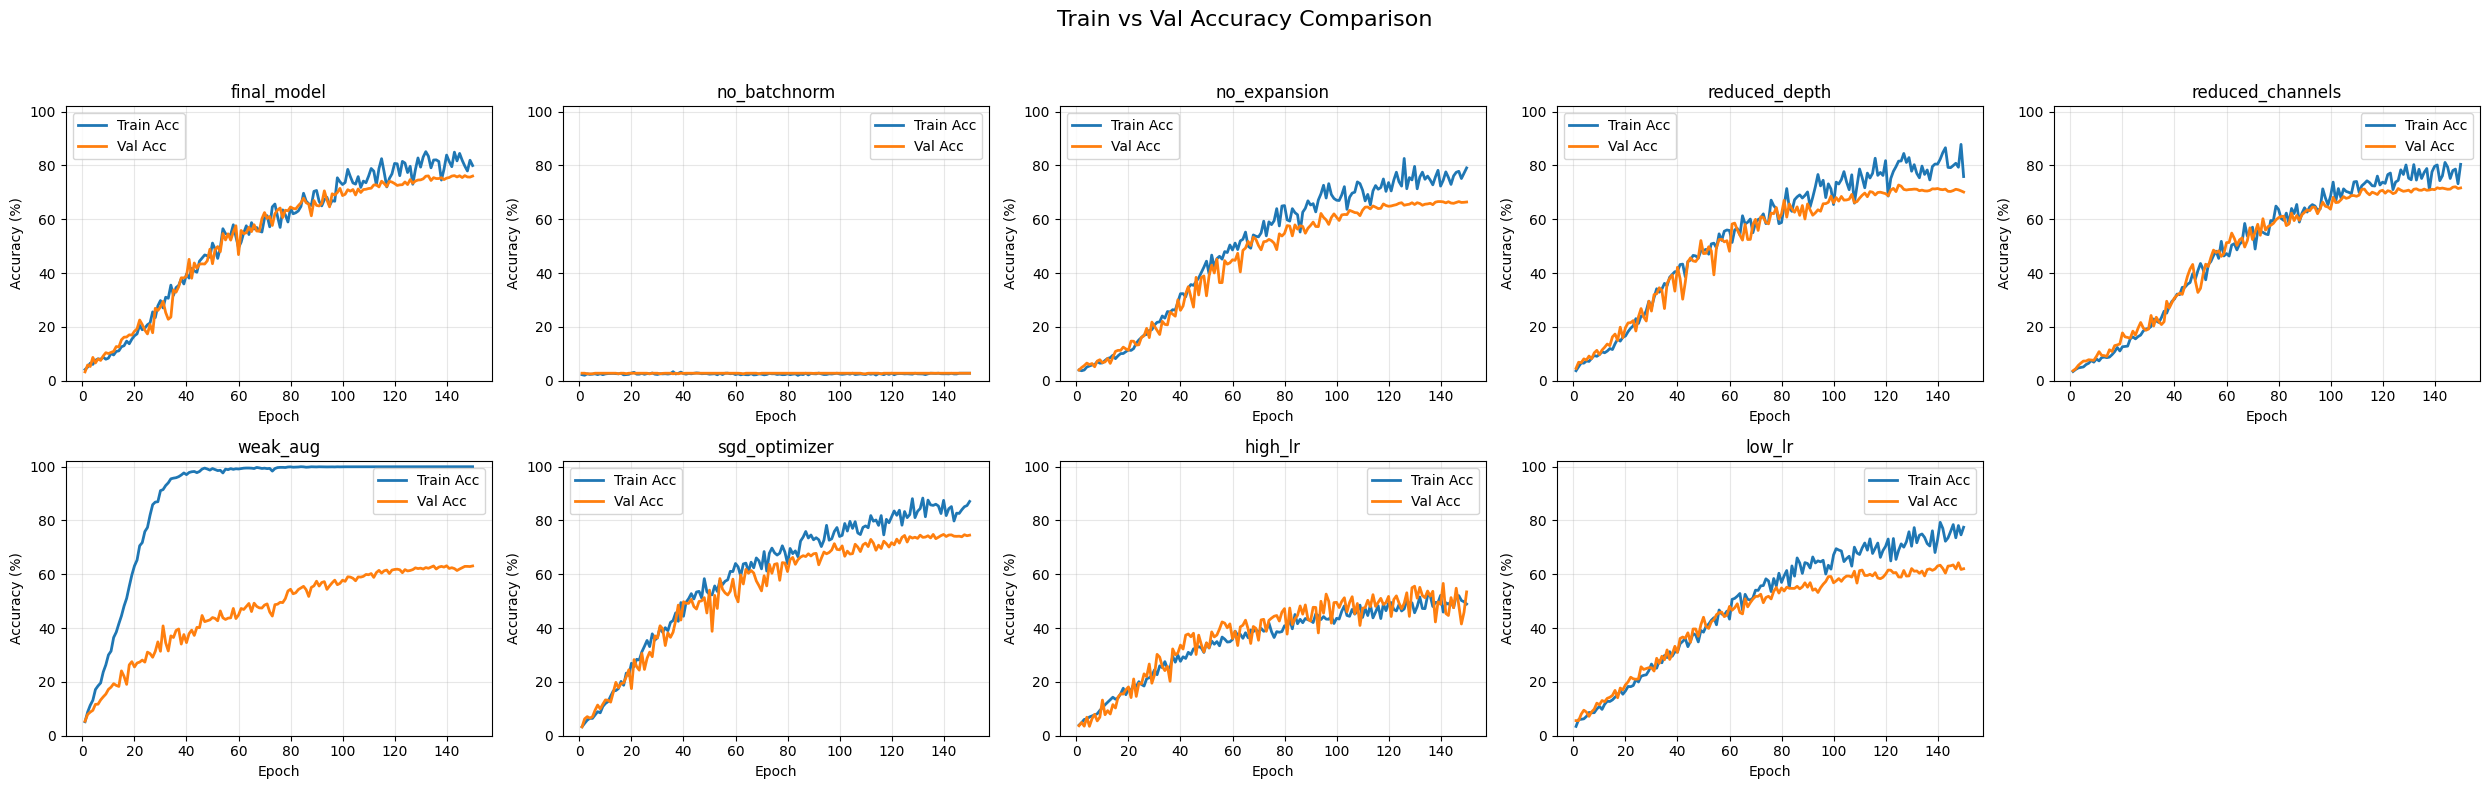

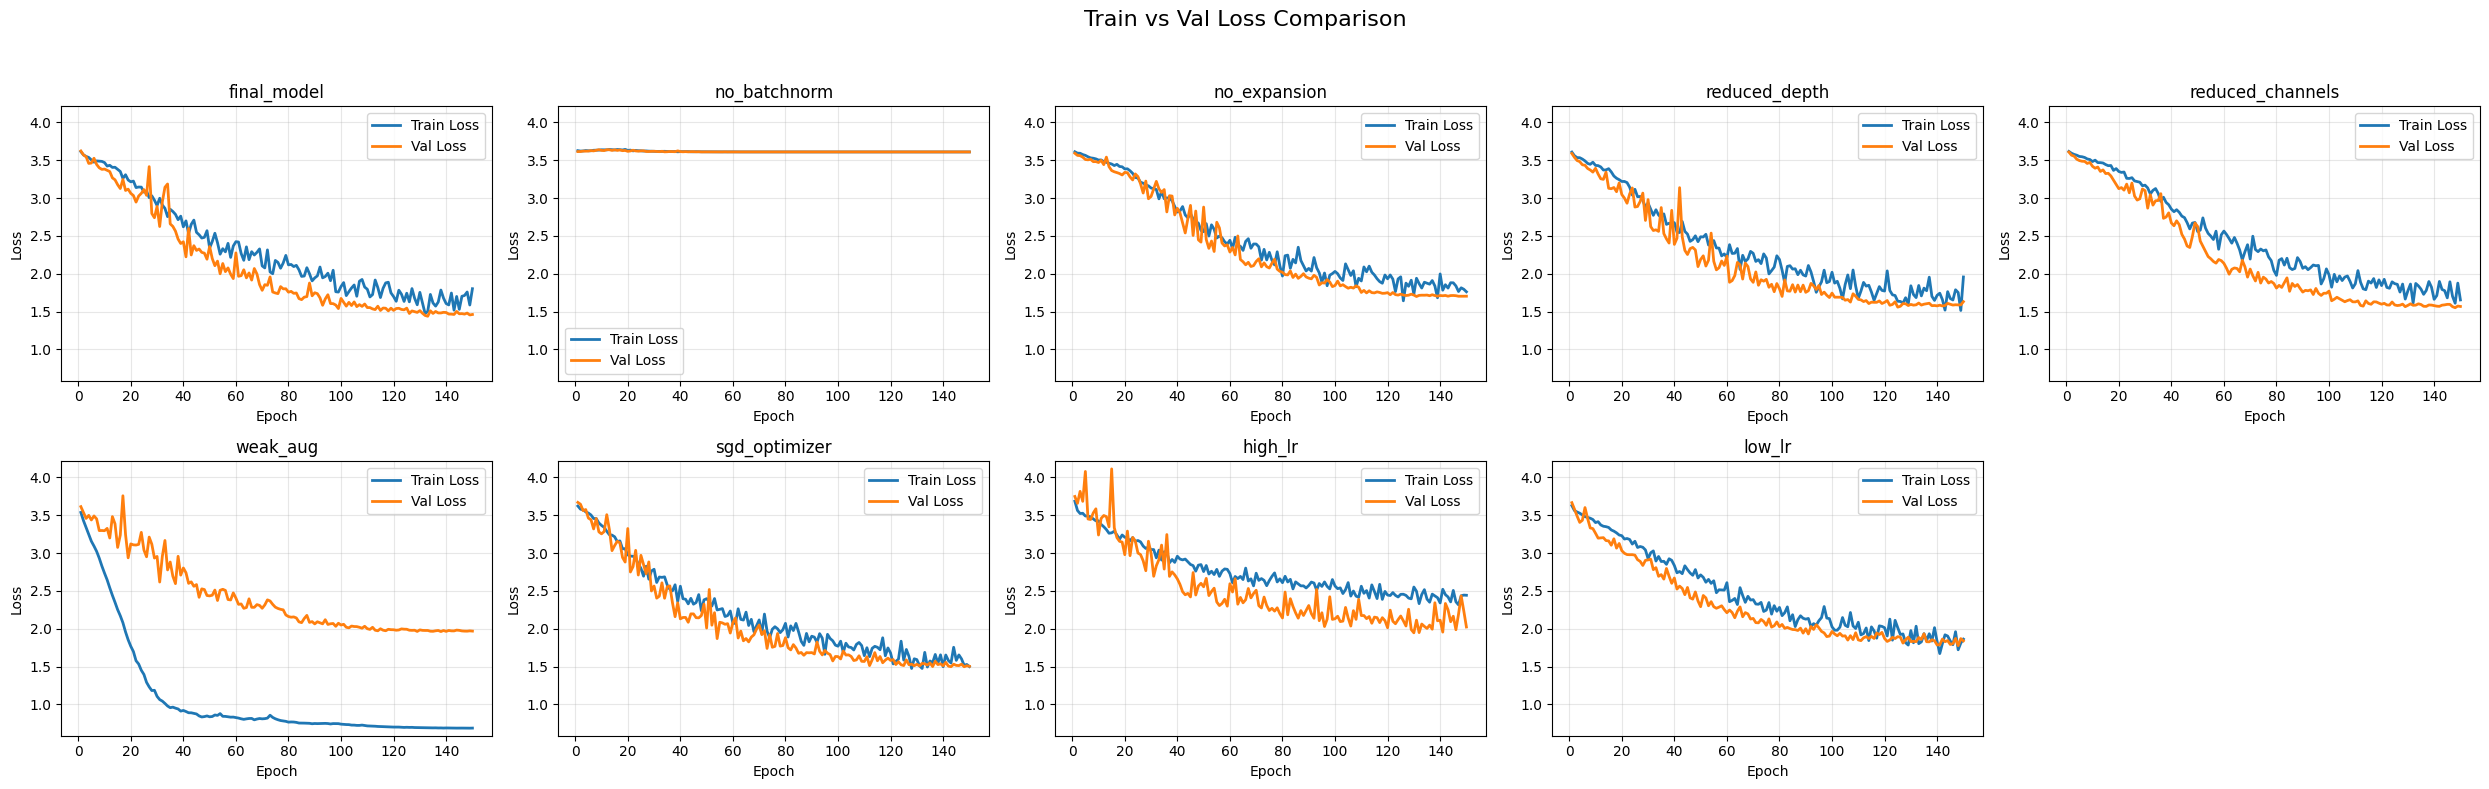

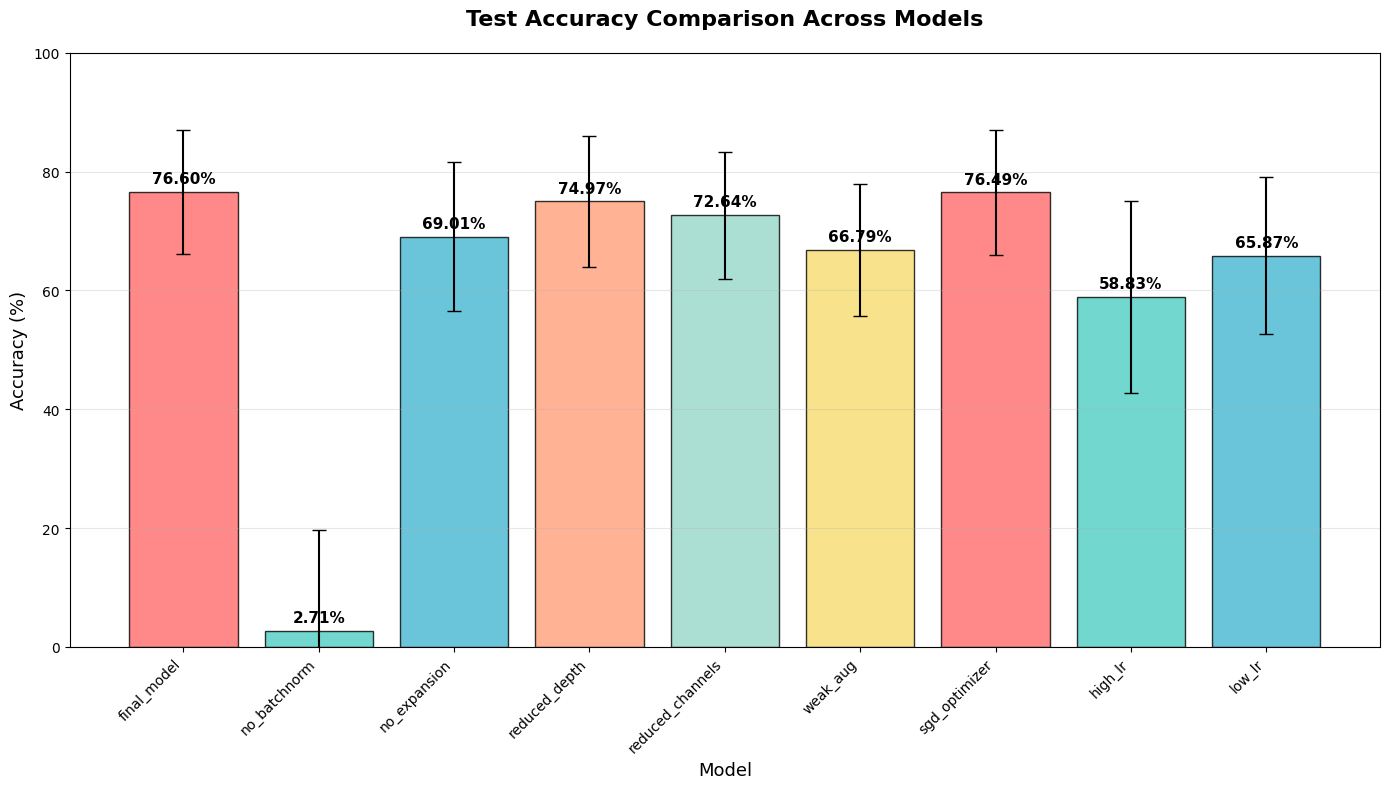

In [6]:
plot_accuracy_fixed({k: histories[k] for k in model_names1 if k in histories})
plot_loss_fixed({k: histories[k] for k in model_names1 if k in histories})
accuracy_comparison_fixed({k: histories[k] for k in model_names1 if k in histories})
display_classification_metrics({k: histories[k] for k in model_names1 if k in histories})

## Part 2A: ResNet-18 Baseline

## Model Overview
*   **`resnet-18_baseline`**: Our starting point, it uses a standard ResNet-18 architecture with the same hyperparameters as the model trained from scratch.

In [36]:
from torchvision.models import resnet18

In [ ]:
print("\nResNet-18 Baseline")
# Initialize ResNet-18
resnet18 = resnet18(weights='IMAGENET1K_V1')
num_classes = 37
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
model_name = 'resnet-18_baseline'

history = train_with_validation(resnet18, model_name, train_loader, val_loader, num_epochs=200, base_path=base_path)
evaluate_accuracy(resnet18, model_name, test_loader, base_path, history)
evaluate_per_class(resnet18, model_name, test_loader, test_dataset, base_path, history)
#Store the results into 'results.json'
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


ResNet-18 Baseline
Epoch 1/200: Train Loss=3.3886, Train Acc=14.61% | Val Loss=2.4929, Val Acc=47.49% | LR=0.000041
Epoch 2/200: Train Loss=2.7969, Train Acc=43.99% | Val Loss=1.8082, Val Acc=71.26% | LR=0.000043
Epoch 3/200: Train Loss=2.5261, Train Acc=52.30% | Val Loss=1.5936, Val Acc=78.08% | LR=0.000046
Epoch 4/200: Train Loss=2.1701, Train Acc=62.85% | Val Loss=1.4515, Val Acc=80.53% | LR=0.000050
Epoch 5/200: Train Loss=2.2173, Train Acc=59.01% | Val Loss=1.3249, Val Acc=82.66% | LR=0.000056
Epoch 6/200: Train Loss=2.0769, Train Acc=67.46% | Val Loss=1.3268, Val Acc=82.66% | LR=0.000064
Epoch 7/200: Train Loss=1.9041, Train Acc=70.16% | Val Loss=1.2337, Val Acc=84.30% | LR=0.000072
Epoch 8/200: Train Loss=1.9144, Train Acc=71.49% | Val Loss=1.2343, Val Acc=83.97% | LR=0.000082
Epoch 9/200: Train Loss=1.9780, Train Acc=69.56% | Val Loss=1.2170, Val Acc=84.62% | LR=0.000092
Epoch 10/200: Train Loss=1.8698, Train Acc=74.71% | Val Loss=1.2461, Val Acc=84.35% | LR=0.000104
Epoch 11/

## Part 2B: Advanced Fine-Tuning Strategies

### Models Overview
Having established our baseline performance with standard ResNet-18 training, we now explore different fine-tuning techniques to maximize model performance.
Our approach follows a methodical progression:
*   **`resnet-18_discr_lr`**: First experiment where we introduce **discriminative learning rates**, where the pretrained backbone has a small learning rate and the newly added classification head has a learning rate 10 times larger.
*   **`resnet18_SGD`**: We switched the optimizer from Adam to **SGD with momentum** to align more closely with common practices in research papers for fine-tuning. Also, we removed the learning rate scheduler for this run.
*   **`resnet18_scheduler`**: Here, we reintroduced a more sophisticated scheduler which uses a **linear warmup** phase for the first 10 epochs, followed by a **cosine annealing** scheduler for the decay phase.
*   **`resnet18_highres`**: Our final and best-performing model, it uses the same scheduler as **`resnet18_scheduler`** but is trained on **higher resolution images** (384x384 instead of 256x256).

### Training Strategy
To manage overfitting, we opted against using a conventional early stopping mechanism that would terminate training. Instead, we trained each model for a fixed number of epochs and saved a checkpoint of the model's state whenever it achieved a new best validation accuracy. The final model used for testing is the one corresponding to this best-performing checkpoint.

This approach was chosen because validation metrics can often plateau or even temporarily degrade for several epochs before improving again. By training for the full duration, we ensure the model has the opportunity to escape these local minima and potentially find a better solution, avoiding premature termination.

### First Approach: Discriminative Learning Rates

Following the fine-tuning methodology described in 'Deep Dive into Deep Learning' (link: https://d2l.ai/chapter_computer-vision/fine-tuning.html ), we implemented discriminative learning rates. This involved assigning a small learning rate (5e-5) to the pretrained backbone and a 10x larger rate (5e-4) to the newly initialized classification head.

The reasoning behind this approach is that the backbone's layers have already learned robust, generic features from ImageNet and require only minor adjustments. In contrast, the classification head is initialized from scratch and needs to learn the specifics of the new dataset more rapidly. This strategy yielded a test accuracy of 87.0%, establishing a strong performance baseline for subsequent experiments.

In [ ]:
def train_with_validation_resnet_discriminative(model, model_name, train_loader, val_loader, num_epochs, base_path, backbone_lr=5e-5, head_lr_multiplier=10, num_classes=37):
    """
    Trains a model using discriminative learning rates and a OneCycleLR scheduler.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        model_name (str): A name for the model, used for saving the checkpoint.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        num_epochs (int): The total number of epochs for training.
        base_path (str): The directory path to save the model checkpoint.
        backbone_lr (float, optional): The base learning rate for the model's backbone.
        head_lr_multiplier (int, optional): Multiplier to determine the head's learning rate.
        num_classes (int, optional): The number of classes for CutMix/MixUp augmentation.

    Returns:
        dict: A dictionary containing the history of training and validation metrics,
              including accuracies, losses, and learning rates for both backbone and head.
    """
    # Set the device to CUDA if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # --- Parameter Separation for Discriminative Learning ---
    # Separate model parameters into two groups: the backbone and the classification head.
    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if 'fc' in name or 'classifier' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)
    
    # Calculate the learning rate for the classification head
    head_lr = backbone_lr * head_lr_multiplier
    
    # --- Optimizer and Scheduler Setup ---
    # Configure the Adam optimizer with two parameter groups, each with a different learning rate.
    optimizer = torch.optim.Adam([
        {'params': backbone_params, 'lr': backbone_lr, 'weight_decay': 1e-4},
        {'params': head_params, 'lr': head_lr, 'weight_decay': 1e-4}
    ])

    # Configure the OneCycleLR scheduler to manage learning rates for both groups.
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[backbone_lr, head_lr],  
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1000
    )

    # Use CrossEntropyLoss with label smoothing for regularization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # --- Data Augmentation Setup ---
    # A random choice is made for each batch to either apply CutMix, MixUp, or no augmentation.
    cutmix = v2.CutMix(num_classes=num_classes)
    mixup = v2.MixUp(num_classes=num_classes)
    identity = v2.Identity()
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])

    # Initialize tracker for the best validation accuracy
    best_val_acc = 0.0

    # Dictionary to store metrics for plotting
    history = {"train_acc": [], "val_acc": [], "backbone_lrs": [], "head_lrs": [] ,"train_loss": [], "val_loss": []}

    # --- Main Training Loop ---
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Apply CutMix or MixUp augmentation
            inputs, targets = cutmix_or_mixup((inputs, targets))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()   
            
            # Log the learning rates for both parameter groups
            current_lrs = scheduler.get_last_lr()
            history["backbone_lrs"].append(current_lrs[0])
            history["head_lrs"].append(current_lrs[1])

            # --- Accumulate Training Statistics ---
            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            # Handle soft labels from augmentations (which are one-hot encoded)
            if targets.ndim == 2:
                targets_labels = targets.argmax(1)
            else:
                targets_labels = targets
            train_correct += (preds == targets_labels).sum().item()
            total_train += targets.size(0)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Accumulate validation statistics
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == targets).sum().item()
                total_val += targets.size(0)

        # --- Calculate and Log Epoch Metrics ---
        avg_train_loss = train_loss / total_train
        avg_val_loss = val_loss / total_val
        train_acc = 100. * train_correct / total_train
        val_acc = 100. * val_correct / total_val

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        # Save the model checkpoint if it has the best validation accuracy so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{base_path}{model_name}.pth")

        # Print a summary of the epoch's performance
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | '
              f'Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}% | '
              f'LR={scheduler.get_last_lr()[0]:.6f}')

    return history

In [ ]:
print("\nResNet-18 Discriminative LR")
# Initialize ResNet-18
resnet18_discr_lr = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_classes = 37
resnet18_discr_lr.fc = nn.Linear(resnet18_discr_lr.fc.in_features, num_classes)
model_name = 'resnet-18_discr_lr'

# --- discriminative learning rates ---
# Adam optimizer + OneCycleLR scheduler.
# Key Hyperparameters:
# - Epochs: 100
# - Backbone Learning Rate: 5e-5 (for the pretrained layers)
# - Head Learning Rate: 5e-4 (10x the backbone LR for the new classifier)
history = train_with_validation_resnet_discriminative(
     model=resnet18_discr_lr,
     model_name = model_name,
     train_loader=train_loader,
     val_loader=val_loader,
     num_epochs=100,
     base_path=base_path,
     backbone_lr=5e-5,      
     head_lr_multiplier=10
 )

evaluate_accuracy(resnet18_discr_lr, model_name, test_loader, base_path, history)
evaluate_per_class(resnet18_discr_lr, model_name, test_loader, test_dataset, base_path, history)

#Store the results
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


ResNet-18 Discriminative LR
Epoch 1/100: Train Loss=3.7961, Train Acc=3.00% | Val Loss=3.6837, Val Acc=3.05% | LR=0.000002
Epoch 2/100: Train Loss=3.6558, Train Acc=4.22% | Val Loss=3.5407, Val Acc=5.45% | LR=0.000003
Epoch 3/100: Train Loss=3.5262, Train Acc=7.25% | Val Loss=3.3903, Val Acc=11.34% | LR=0.000003
Epoch 4/100: Train Loss=3.4554, Train Acc=10.08% | Val Loss=3.2186, Val Acc=19.41% | LR=0.000004
Epoch 5/100: Train Loss=3.3048, Train Acc=18.94% | Val Loss=2.9874, Val Acc=29.23% | LR=0.000005
Epoch 6/100: Train Loss=3.2083, Train Acc=24.04% | Val Loss=2.7025, Val Acc=40.57% | LR=0.000007
Epoch 7/100: Train Loss=3.0087, Train Acc=32.52% | Val Loss=2.3768, Val Acc=52.73% | LR=0.000008
Epoch 8/100: Train Loss=2.8416, Train Acc=38.24% | Val Loss=2.0718, Val Acc=64.23% | LR=0.000010
Epoch 9/100: Train Loss=2.7399, Train Acc=45.13% | Val Loss=1.8266, Val Acc=72.25% | LR=0.000012
Epoch 10/100: Train Loss=2.4319, Train Acc=54.70% | Val Loss=1.6452, Val Acc=77.15% | LR=0.000014
Epoch

### Second Approach: Change in the Optimizer

In this experiment, we switched from the Adam optimizer to SGD with momentum, aligning our approach with common practices in fine-tuning literature. We also removed the learning rate scheduler to better isolate the effects of the optimizer change. This simplification of the training process, even with a higher learning rate, resulted in a slight performance boost, achieving a test accuracy of 87.97%.

In [ ]:
def train_with_validation_resnet_SGD(model, model_name, train_loader, val_loader, num_epochs, base_path, backbone_lr=1e-3, head_lr_multiplier=10, num_classes=37):
    """
    Train with discriminative learning rates using SGD with momentum.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        model_name (str): A name for the model, used for saving the checkpoint.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        num_epochs (int): The total number of epochs for training.
        base_path (str): The directory path to save the model checkpoint.
        backbone_lr (float, optional): The base learning rate for the model's backbone.
        head_lr_multiplier (int, optional): Multiplier to determine the head's learning rate.
        num_classes (int, optional): The number of classes for CutMix/MixUp augmentation.

    Returns:
        dict: A dictionary containing the history of training and validation metrics,
              including accuracies, losses, and learning rates for both backbone and head.

    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    backbone_params = []
    head_params = []

    for name, param in model.named_parameters():
        if 'fc' in name or 'classifier' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)
    
    # --- KEY CHANGE 1: Switched to SGD with momentum ---
    # The tutorial uses SGD with a weight decay of 0.001 and adds momentum
    head_lr = backbone_lr * head_lr_multiplier
    optimizer = torch.optim.SGD([
        {'params': backbone_params, 'lr': backbone_lr},
        {'params': head_params, 'lr': head_lr}
    ], weight_decay=0.001)

    # --- KEY CHANGE 2: Removed the OneCycleLR scheduler ---
    # The target implementation uses a fixed learning rate throughout training.
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    cutmix = v2.CutMix(num_classes=num_classes)
    mixup = v2.MixUp(num_classes=num_classes)
    identity = v2.Identity()
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])

    best_val_acc = 0.0

    history = {"train_acc": [], "val_acc": [], "backbone_lrs": [], "head_lrs": [] , "train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = cutmix_or_mixup((inputs, targets))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            current_lrs = [g['lr'] for g in optimizer.param_groups]
            history["backbone_lrs"].append(current_lrs[0])  # Backbone LR
            history["head_lrs"].append(current_lrs[1])      # Head LR

           
            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            if targets.ndim == 2: 
                targets_labels = targets.argmax(1)
            else:
                targets_labels = targets
            train_correct += (preds == targets_labels).sum().item()
            total_train += targets.size(0)

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == targets).sum().item()
                total_val += targets.size(0)

        # Metrics per epoch
        avg_train_loss = train_loss / total_train
        avg_val_loss = val_loss / total_val
        train_acc = 100. * train_correct / total_train
        val_acc = 100. * val_correct / total_val

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{base_path}{model_name}.pth")

        current_lrs = [g['lr'] for g in optimizer.param_groups]
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | '
              f'Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}% | '
              f'Backbone LR={current_lrs[0]:.6f}, Head LR={current_lrs[1]:.6f}')

    return history

In [ ]:
print("\nResNet-18 SGD")
# Initialize ResNet-18
resnet18_SGD = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_classes = 37
resnet18_SGD.fc = nn.Linear(resnet18_SGD.fc.in_features, num_classes)
model_name = 'resnet18_SGD'

# --- SGD optimizer  with Momentum,  No scheduler---

# Key Hyperparameters:
# - Optimizer: SGD with momentum
# - Epochs: 100
# - Backbone Learning Rate: 5e-4
# - Head Learning Rate: 5e-3 (10x the backbone LR)

history = train_with_validation_resnet_SGD(
     model=resnet18_SGD,
     model_name = model_name,
     train_loader=train_loader,
     val_loader=val_loader,
     num_epochs=100,
     base_path=base_path,
     backbone_lr=5e-4,      
     head_lr_multiplier=10 
 )

evaluate_accuracy(resnet18_SGD, model_name, test_loader, base_path, history)
evaluate_per_class(resnet18_SGD, model_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


ResNet-18 SGD
Epoch 1/100: Train Loss=3.6349, Train Acc=4.03% | Val Loss=3.4416, Val Acc=9.71% | Backbone LR=0.000500, Head LR=0.005000
Epoch 2/100: Train Loss=3.4817, Train Acc=9.21% | Val Loss=3.2074, Val Acc=22.41% | Backbone LR=0.000500, Head LR=0.005000
Epoch 3/100: Train Loss=3.3619, Train Acc=16.60% | Val Loss=2.9899, Val Acc=34.46% | Backbone LR=0.000500, Head LR=0.005000
Epoch 4/100: Train Loss=3.2491, Train Acc=22.79% | Val Loss=2.8062, Val Acc=42.37% | Backbone LR=0.000500, Head LR=0.005000
Epoch 5/100: Train Loss=3.0875, Train Acc=32.11% | Val Loss=2.6117, Val Acc=51.64% | Backbone LR=0.000500, Head LR=0.005000
Epoch 6/100: Train Loss=2.9951, Train Acc=36.63% | Val Loss=2.4188, Val Acc=56.05% | Backbone LR=0.000500, Head LR=0.005000
Epoch 7/100: Train Loss=2.8731, Train Acc=40.17% | Val Loss=2.2519, Val Acc=62.10% | Backbone LR=0.000500, Head LR=0.005000
Epoch 8/100: Train Loss=2.8041, Train Acc=43.01% | Val Loss=2.1245, Val Acc=65.49% | Backbone LR=0.000500, Head LR=0.005

### Third Approach: Reintroducing a Learning Rate Scheduler

Building on the stability of SGD, we reintroduced a learning rate scheduler to address the underfitting observed in the previous experiment. We implemented a composite scheduler featuring a linear warmup phase followed by cosine annealing. The warmup period allows the model to adapt to the new task with small, stable updates, preventing the disruption of valuable pretrained features. Subsequently, the cosine decay smoothly lowers the learning rate, enabling the model to fine-tune its parameters and converge to a more optimal solution. This management of the learning rate proved effective boosting test accuracy to 88.84%.

In [ ]:
def train_with_validation_resnet_cosine_annealing(model, model_name, train_loader, val_loader, num_epochs, base_path, backbone_lr=1e-3, head_lr_multiplier=10, warmup = 10, num_classes=37):
    """
    Trains a model using SGD with momentum, discriminative learning rates, and a
    cosine annealing scheduler with a linear warmup phase.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        model_name (str): A name for the model, used for saving the checkpoint.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        num_epochs (int): The total number of epochs for training.
        base_path (str): The directory path to save the model checkpoint.
        backbone_lr (float, optional): The base learning rate for the model's backbone.
        head_lr_multiplier (int, optional): Multiplier for the head's learning rate.
        warmup (int, optional): The number of epochs for the linear warmup phase.
        num_classes (int, optional): The number of classes for CutMix/MixUp augmentation.

    Returns:
        dict: A dictionary containing the history of training and validation metrics.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if 'fc' in name or 'classifier' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)
    
    
    head_lr = backbone_lr * head_lr_multiplier
    
    # --- Optimizer and Scheduler Setup ---
    # Use SGD with Nesterov momentum.
    optimizer = torch.optim.SGD([
        {'params': backbone_params, 'lr': backbone_lr, 'weight_decay': 1e-4},
        {'params': head_params, 'lr': head_lr, 'weight_decay': 1e-4}
    ], momentum=0.9, nesterov=True)

    # Main scheduler: Cosine Annealing decays the learning rate following a cosine curve.
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs - warmup, eta_min=1e-6)
    
    # Warmup scheduler: Linearly increases the learning rate for the first few epochs.
    warmup_epochs = warmup
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs
    )

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    cutmix = v2.CutMix(num_classes=num_classes)
    mixup = v2.MixUp(num_classes=num_classes)
    identity = v2.Identity()
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])

    best_val_acc = 0.0

    # Dictionary to store metrics for plotting
    history = {"train_acc": [], "val_acc": [], "backbone_lrs": [], "head_lrs": [] ,"train_loss": [], "val_loss": []}

    # --- Main Training Loop ---
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Apply CutMix or MixUp augmentation
            inputs, targets = cutmix_or_mixup((inputs, targets))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            # Clip gradients to a maximum norm of 1.0 to prevent them from exploding.
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # --- Accumulate Training Statistics ---
            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
  
            if targets.ndim == 2:
                targets_labels = targets.argmax(1)
            else:
                targets_labels = targets
            train_correct += (preds == targets_labels).sum().item()
            total_train += targets.size(0)
        
        # --- Learning Rate Scheduling Step ---
        # Apply warmup scheduler during warmup phase, then switch to cosine annealing.
        if epoch < warmup_epochs:
            warmup_scheduler.step()
        else:
            scheduler.step()

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Accumulate validation statistics
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == targets).sum().item()
                total_val += targets.size(0)

        # --- Calculate and Log Epoch Metrics ---
        avg_train_loss = train_loss / total_train
        avg_val_loss = val_loss / total_val
        train_acc = 100. * train_correct / total_train
        val_acc = 100. * val_correct / total_val

        # Store learning rates for both parameter groups
        current_backbone_lr = optimizer.param_groups[0]['lr']
        current_head_lr = optimizer.param_groups[1]['lr']

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["backbone_lrs"].append(current_backbone_lr)
        history["head_lrs"].append(current_head_lr)

        # Save the model checkpoint if it has the best validation accuracy so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{base_path}{model_name}.pth")

        # Print a summary of the epoch's performance
        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | '
              f'Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}% | '
              f'Backbone LR={current_backbone_lr:.6f}, Head LR={current_head_lr:.6f}')

    return history


In [ ]:
print("\nResNet-18 Improved Scheduler")
# Initialize ResNet-18
resnet18_scheduler = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_classes = 37
resnet18_scheduler.fc = nn.Linear(resnet18_scheduler.fc.in_features, num_classes)
model_name = 'resnet18_scheduler'

# --- Train with SGD, Cosine Annealing, and Warmup ---
# Key Hyperparameters:
# - Optimizer: SGD with Nesterov momentum
# - Scheduler: Linear Warmup (10 epochs) + Cosine Annealing
# - Epochs: 100
# - Backbone Learning Rate: 2e-3
# - Head Learning Rate: 1e-2 (5x the backbone LR)
history = train_with_validation_resnet_cosine_annealing(
     model=resnet18_scheduler,
     model_name = model_name,
     train_loader=train_loader,
     val_loader=val_loader,
     num_epochs=100,
     base_path=base_path,
     backbone_lr=2e-3,      
     head_lr_multiplier=5 
 )

evaluate_accuracy(resnet18_scheduler, model_name, test_loader, base_path, history)
evaluate_per_class(resnet18_scheduler, model_name, test_loader, test_dataset, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


ResNet-18 Improved Scheduler
Epoch 1/100: Train Loss=3.7335, Train Acc=3.43% | Val Loss=3.5776, Val Acc=4.47% | Backbone LR=0.000380, Head LR=0.001900
Epoch 2/100: Train Loss=3.5691, Train Acc=6.73% | Val Loss=3.3542, Val Acc=13.14% | Backbone LR=0.000560, Head LR=0.002800
Epoch 3/100: Train Loss=3.4165, Train Acc=14.58% | Val Loss=3.0457, Val Acc=31.08% | Backbone LR=0.000740, Head LR=0.003700
Epoch 4/100: Train Loss=3.2277, Train Acc=24.07% | Val Loss=2.6593, Val Acc=49.51% | Backbone LR=0.000920, Head LR=0.004600
Epoch 5/100: Train Loss=2.9672, Train Acc=35.87% | Val Loss=2.2154, Val Acc=62.81% | Backbone LR=0.001100, Head LR=0.005500
Epoch 6/100: Train Loss=2.7424, Train Acc=43.53% | Val Loss=1.8503, Val Acc=72.41% | Backbone LR=0.001280, Head LR=0.006400
Epoch 7/100: Train Loss=2.5123, Train Acc=53.58% | Val Loss=1.5945, Val Acc=78.03% | Backbone LR=0.001460, Head LR=0.007300
Epoch 8/100: Train Loss=2.3805, Train Acc=57.51% | Val Loss=1.4630, Val Acc=80.21% | Backbone LR=0.001640

### Fourth Approach: High-Resolution Training

Having optimized our training strategy with discriminative learning rates and a cosine annealing scheduler, we shifted our focus to the input data itself. The hypothesis was that providing the model with higher-resolution images would allow it to learn more fine-grained features and push performance further.

To test this, we increased the input image resolution from 256x256 to 384x384, while retaining the successful training configuration from the previous experiment. Recognizing that learning from more detailed images might require additional time to converge, we also extended the training period to 120 epochs to see if the model could capitalize on any late-stage improvements.

This data-centric approach proved to be the final key, in fact, the model achieved a **90.46%** test accuracy  successfully breaking our 90% performance target.

In [64]:
# Higher resolution transforms for better feature extraction
highres_train_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomResizedCrop(320, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    RandAugment(num_ops=2, magnitude=8),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.3), ratio=(0.3, 3.3))
])

highres_val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

# Create high-resolution datasets
train_dataset_highres = OxfordPetDataset('train', transform=highres_train_transform)
val_dataset_highres = OxfordPetDataset('val', transform=highres_val_transform)
test_dataset_highres = OxfordPetDataset('test', transform=highres_val_transform)

# Create high-resolution data loaders
train_loader_highres = DataLoader(train_dataset_highres, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_highres = DataLoader(val_dataset_highres, batch_size=batch_size)
test_loader_highres = DataLoader(test_dataset_highres, batch_size=batch_size)

In [ ]:
print("\nResNet-18 High Res")
# Initialize ResNet-18
resnet18_highres = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_classes = 37
resnet18_highres.fc = nn.Linear(resnet18_highres.fc.in_features, num_classes)
model_name = 'resnet18_highres'

history = train_with_validation_resnet_cosine_annealing(
     model=resnet18_highres,
     model_name = model_name,
     train_loader=train_loader_highres,
     val_loader=val_loader_highres,
     num_epochs=120,
     base_path=base_path,
     backbone_lr=2e-3,      
     head_lr_multiplier=5,
     warmup=20
 )

evaluate_accuracy(resnet18_highres, model_name, test_loader_highres, base_path, history)
evaluate_per_class(resnet18_highres, model_name, test_loader_highres, test_dataset_highres, base_path, history)
with open(f"{base_path}results.json", "r+") as file:
    file_data = json.load(file)
    file_data[model_name] = history
    file.seek(0)
    json.dump(file_data, file, indent=4)


ResNet-18 High Res
Epoch 1/120: Train Loss=3.7247, Train Acc=2.53% | Val Loss=3.6419, Val Acc=3.00% | Backbone LR=0.000290, Head LR=0.001450
Epoch 2/120: Train Loss=3.5965, Train Acc=4.42% | Val Loss=3.4848, Val Acc=7.96% | Backbone LR=0.000380, Head LR=0.001900
Epoch 3/120: Train Loss=3.4919, Train Acc=8.89% | Val Loss=3.2956, Val Acc=17.23% | Backbone LR=0.000470, Head LR=0.002350
Epoch 4/120: Train Loss=3.3515, Train Acc=17.96% | Val Loss=3.0667, Val Acc=30.59% | Backbone LR=0.000560, Head LR=0.002800
Epoch 5/120: Train Loss=3.2356, Train Acc=26.66% | Val Loss=2.7867, Val Acc=45.09% | Backbone LR=0.000650, Head LR=0.003250
Epoch 6/120: Train Loss=3.0486, Train Acc=36.17% | Val Loss=2.4842, Val Acc=57.25% | Backbone LR=0.000740, Head LR=0.003700
Epoch 7/120: Train Loss=2.8272, Train Acc=45.87% | Val Loss=2.1448, Val Acc=65.10% | Backbone LR=0.000830, Head LR=0.004150
Epoch 8/120: Train Loss=2.6197, Train Acc=53.94% | Val Loss=1.8632, Val Acc=71.86% | Backbone LR=0.000920, Head LR=0.

# Results Analysis

### Analysis of Training Dynamics

*   **`resnet_baseline`**: Our initial baseline model started strong, showing rapid learning on both the training and validation sets. However, this momentum did not hold, in fact, in the later epochs the model began to overfit; its performance on the training data continued to climb while its ability to generalize to the unseen validation data stagnated. This behavior indicates that our initial learning rate strategy, while powerful, was not well-suited for fine-tuning, pointing towards the need for a more delicate approach that could preserve the integrity of the pre-trained weights.

*   **`discr_lr` (Discriminative Learning Rates)**: To address the instability of the baseline, our first refinement was to introduce discriminative learning rates. This change had an immediate and positive impact, yielding a much more stable training process. The validation accuracy and loss curves smoothed out considerably, indicating that the model was no longer making destructive updates to its valuable pre-trained features. While the training metrics remained somewhat volatile,an expected outcome given our strong data augmentation, the key improvement was in the model's ability to generalize. Confirming that protecting the backbone with a lower learning rate is a powerful strategy to reduce overfitting and guide the model towards a more robust solution.

*   **`SGD`**:  Changing from Adam to SGD and removing the scheduler brought a new kind of stability; the training curves became smoother, in contrast with the volatility of the baseline. However, this smoothness came at a cost: the model began to underfit. Without a dynamic learning rate, the model lacked the ability to make finer adjustments in the later stages of training, ultimately getting stuck in a suboptimal state.

*   **`Scheduler`**: Introducing a warmup and cosine decay schedule improves convergence substantially. Training and validation curves stay closely aligned, indicating strong generalization. The decaying learning rate allows the optimizer to make large updates early on, then gradually refine, leading to stable convergence.

*   **`highres` (High Resolution)**:  Having optimized our training strategy, we noticed that increasing the input resolution further enhances performance. Training remains stable and well-regularized, while validation accuracy improves. This suggests the model benefits from richer visual detail, confirming that once optimization is tuned, higher-quality input data can yield additional gains without introducing overfitting.

### Test Accuracy Comparison

The bar plot of test accuracies provides a clear summary of our experimental progression. Each modification, from discriminative learning rates to an advanced scheduler and finally to higher resolution data contributes to a steady increase in performance. The final `highres` model achieves the highest accuracy, with small error bars indicating that its strong performance is consistent and reliable across different batches of the test set.

### Macro-Averaged Classification Metrics
The improvements are not only reflected in the overall accuracy but are also consistently supported by other key classification metrics. The table shows a steady increase in macro-averaged precision, recall, and F1-score with each experimental refinement demonstrating that our final model is not just more accurate, but also more balanced in its ability to correctly identify positive cases and maintain a low false positive rate.

In [7]:
# Load history from results.json
with open(f"{base_path}results.json", "r") as file:
    histories = json.load(file)

In [8]:
model_names2 = [
    "resnet-18_baseline",
    "resnet-18_discr_lr",
    "resnet18_SGD",
    "resnet18_scheduler",
    "resnet18_highres"
]

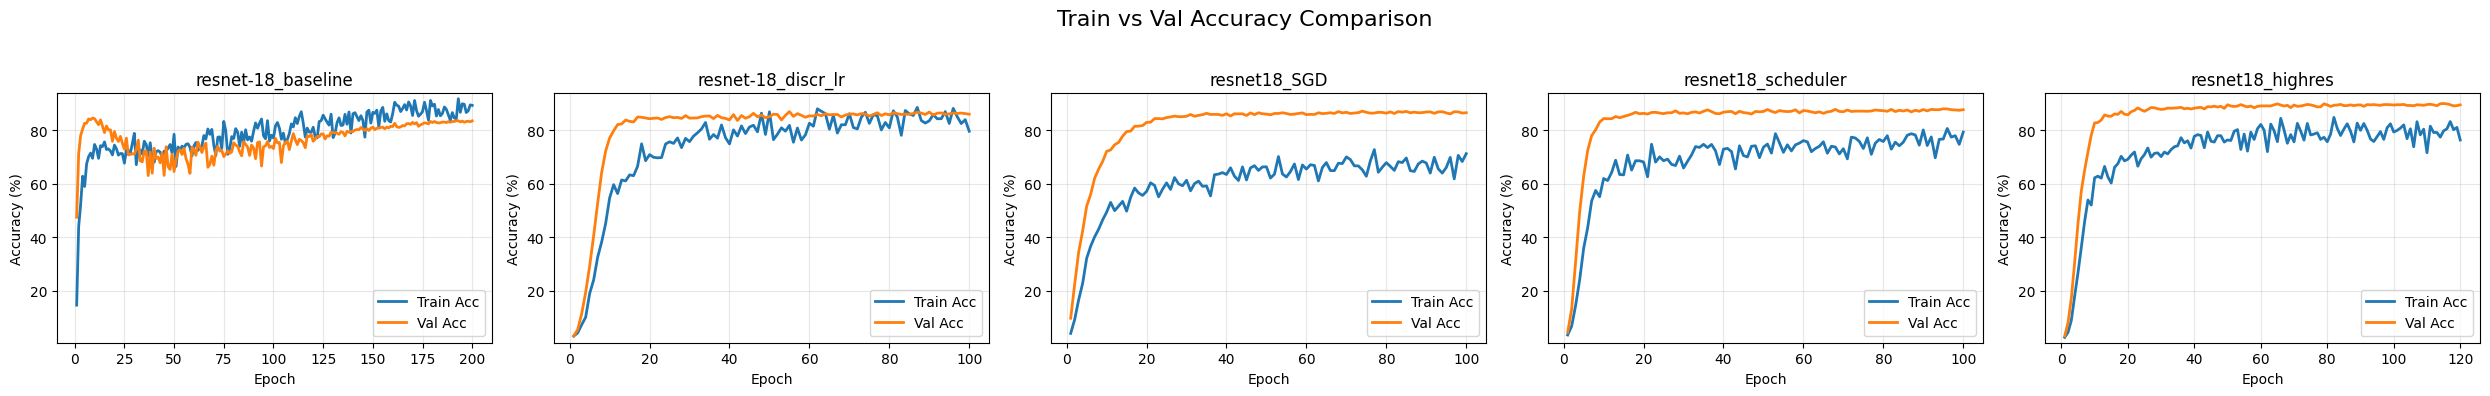

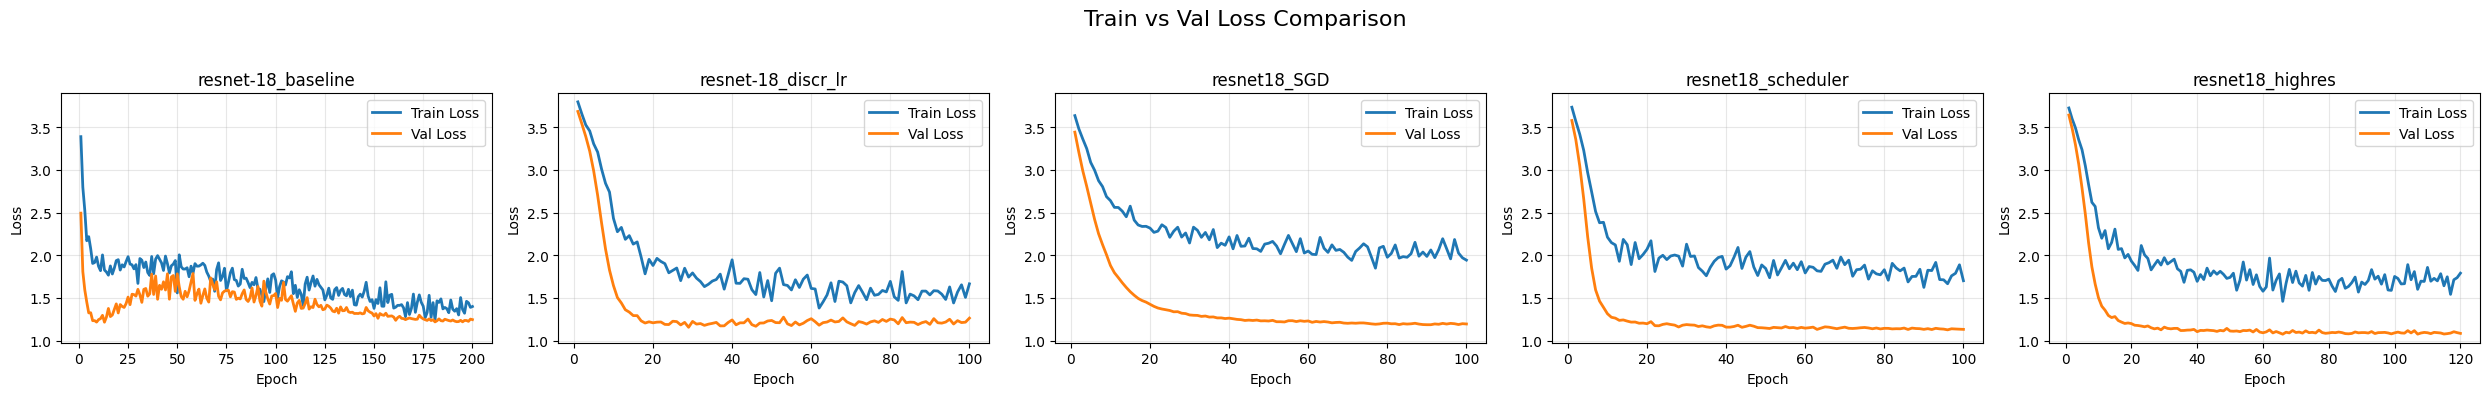

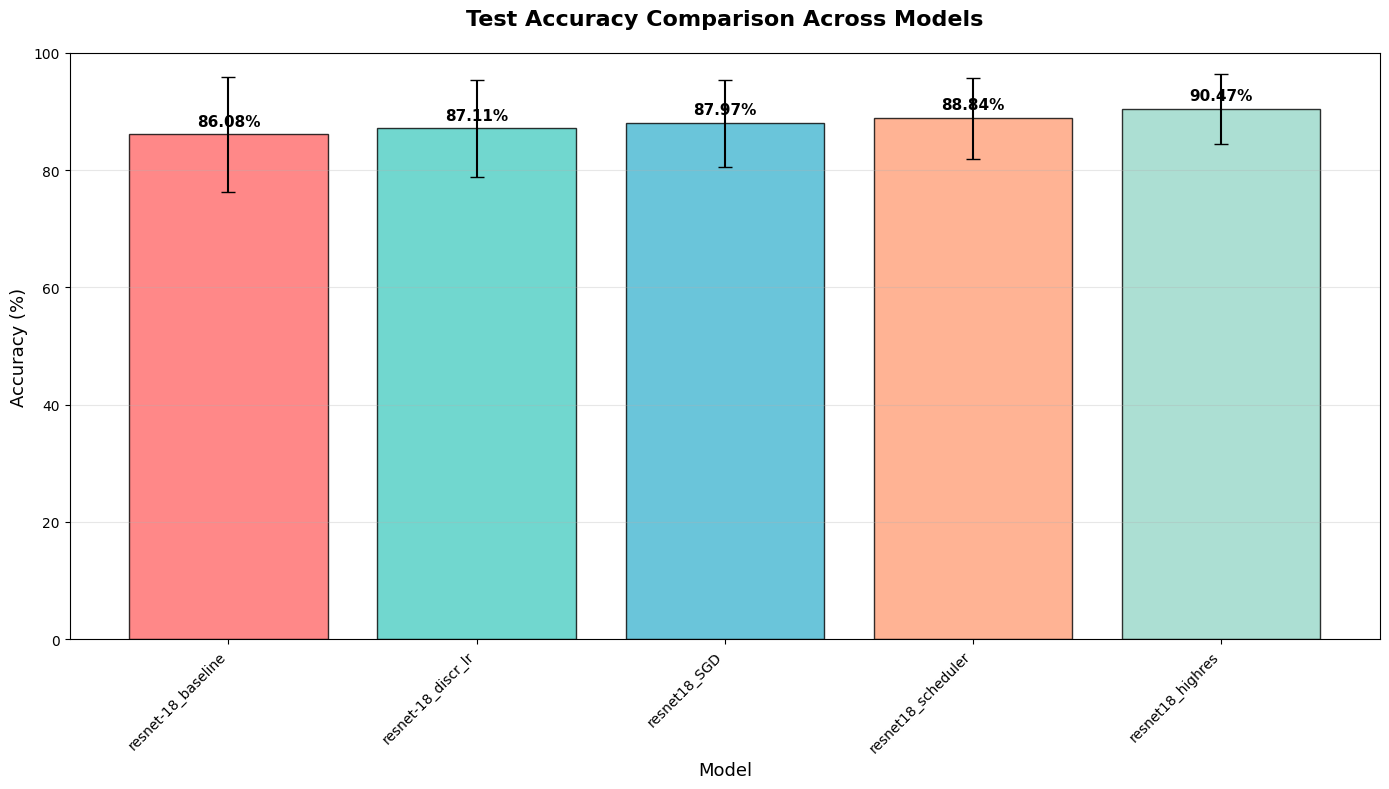

In [9]:
plot_accuracy_fixed({k: histories[k] for k in model_names2 if k in histories})
plot_loss_fixed({k: histories[k] for k in model_names2 if k in histories})
accuracy_comparison_fixed({k: histories[k] for k in model_names2 if k in histories})
display_classification_metrics({k: histories[k] for k in model_names2 if k in histories})

# Final Comparison and Challenges Analysis

In this final section, we conduct an analysis of the classification performance between our two best-performing models: **final_model** (trained from scratch, 76% accuracy) and **resnet18_highres** (ResNet-18 fine tuned, 90.46% accuracy).

## Confusion Matrix Analysis

The confusion matrices reveal that while both models achieve strong overall performance, they face systematic challenges with specific breed pairs that share similar visual characteristics. The most problematic classifications for both architectures include:

- **American Pit Bull Terrier vs Staffordshire Bull Terrier**: Both breeds share muscular builds, similar head shapes, and comparable coat patterns
- **Ragdoll vs Birman**: These cat breeds exhibit nearly identical long-haired coats and color point patterns
- **British Shorthair vs Russian Blue**: Both feature dense, short coats and similar facial structures, differing primarily in subtle coat color variations


## Most Confused Pairs Analysis

The heatmaps display the top 6 most confused pairs. Each 2×2 confusion matrix shows normalized prediction probabilities, where off-diagonal values represent misclassification rates. For instance, the Ragdoll-Birman confusion demonstrates that both models struggle with this particular distinction, with significant cross-predictions in both directions. This bidirectional confusion suggests that the visual features distinguishing these breeds fall below the discriminative threshold of both architectures. Notably, the ResNet model shows more confident and accurate predictions even for these challenging pairs.

## Per-Class Performance Comparison

The accuracy tables reveal substantial performance differences between the two models across individual classes. ResNet demonstrates more uniform performance across all classes also showing marked improvement on challenging breeds. On the other hand, our MobileNet inspired network shows larger performance gaps between easy and difficult classes. This may be due to the fact that without pretrained features, the model must learn all visual representations from the limited pet dataset.

In [65]:
def analyze_confusion_matrix(model, model_name, test_loader, dataset, base_path, class_names, top_k=5):
    """
    Comprehensive confusion matrix analysis with visualization and failure case identification.
    
    Args:
        model: PyTorch model to analyze
        model_name: Name of the model for loading checkpoint
        test_loader: DataLoader for test dataset
        dataset: Dataset object for accessing raw images
        base_path: Path where model checkpoint is saved
        class_names: List of class names
        top_k: Number of most confused pairs to show
    
    Returns:
        dict: Analysis results including confusion matrix and most confused pairs
    """
    
    # Set model to evaluation mode and load best weights
    model.eval()
    model.to(device)
    model.load_state_dict(torch.load(f"{base_path}{model_name}.pth", map_location=device))
    
    # Collect predictions and true labels
    all_preds = []
    all_labels = []
    prediction_details = []  
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            predicted = outputs.argmax(1)
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Store detailed info for failure analysis
            for i in range(len(images)):
                prediction_details.append({
                    'batch_idx': batch_idx,
                    'sample_idx': i,
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item(),
                    'confidence': probabilities[i].max().item(),
                    'top_3_probs': probabilities[i].topk(3)[0].cpu().numpy(),
                    'top_3_classes': probabilities[i].topk(3)[1].cpu().numpy(),
                    'is_correct': (predicted[i] == labels[i]).item()
                })
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate per-class accuracies
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # 1. CONFUSION MATRIX HEATMAP
    plt.figure(figsize=(20, 16))
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    

    sns.heatmap(cm_normalized, 
                annot=False,
                cmap='Blues', 
                xticklabels=[name.replace('_', ' ').title() for name in class_names],
                yticklabels=[name.replace('_', ' ').title() for name in class_names],
                cbar_kws={'label': 'Prediction Probability'})
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 2. IDENTIFY MOST CONFUSED CLASS PAIRS
    confused_pairs = []
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:  # Off-diagonal elements
                confusion_rate = cm[i, j] / cm[i].sum()  # Rate of misclassifying i as j
                confused_pairs.append({
                    'true_class': class_names[i],
                    'predicted_class': class_names[j], 
                    'count': cm[i, j],
                    'confusion_rate': confusion_rate,
                    'true_idx': i,
                    'pred_idx': j
                })
    
    # Sort by confusion rate
    confused_pairs.sort(key=lambda x: x['confusion_rate'], reverse=True)


    # 3. VISUALIZE MOST CONFUSED PAIRS
    _, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, pair in enumerate(confused_pairs[:6]):  # Show top 6 pairs
        if idx >= 6:
            break
            
        ax = axes[idx]
        
        # Create mini confusion matrix for this pair
        true_idx, pred_idx = pair['true_idx'], pair['pred_idx']
        
        # Extract 2x2 submatrix for these two classes
        mini_cm = np.array([
            [cm[true_idx, true_idx], cm[true_idx, pred_idx]],
            [cm[pred_idx, true_idx], cm[pred_idx, pred_idx]]
        ])
        
        # Normalize
        mini_cm_norm = mini_cm.astype('float') / mini_cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(mini_cm_norm, 
                   annot=True, 
                   fmt='.2f',
                   cmap='Reds',
                   xticklabels=[pair['predicted_class'].replace('_', ' ').title()[:10], 
                               pair['true_class'].replace('_', ' ').title()[:10]],
                   yticklabels=[pair['true_class'].replace('_', ' ').title()[:10],
                               pair['predicted_class'].replace('_', ' ').title()[:10]],
                   ax=ax,
                   cbar=False)
        
        ax.set_title(f" {pair['true_class'].replace('_', ' ').title()[:12]} → {pair['predicted_class'].replace('_', ' ').title()[:12]}")
    
    plt.suptitle(f'Most Confused Class Pairs - {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Create DataFrame for better visualization
    performance_data = []
    for i, class_name in enumerate(class_names):
        performance_data.append({
            'Class': class_name.replace('_', ' ').title(),
            'Accuracy': per_class_accuracy[i]
        })
    
    # Sort by accuracy
    performance_data.sort(key=lambda x: x['Accuracy'])
    
    df = pd.DataFrame(performance_data)
    
    df.sort_values(by=['Accuracy'], ascending=False, inplace=True)

    # Or if you want to format multiple numeric columns:
    display(df.style.format({
        'Accuracy': '{:.4f}',
        'Total_Samples': '{:.0f}',
        'Correct_Predictions': '{:.0f}'
    }).set_caption("Per-Class Performance Summary"))
    return df

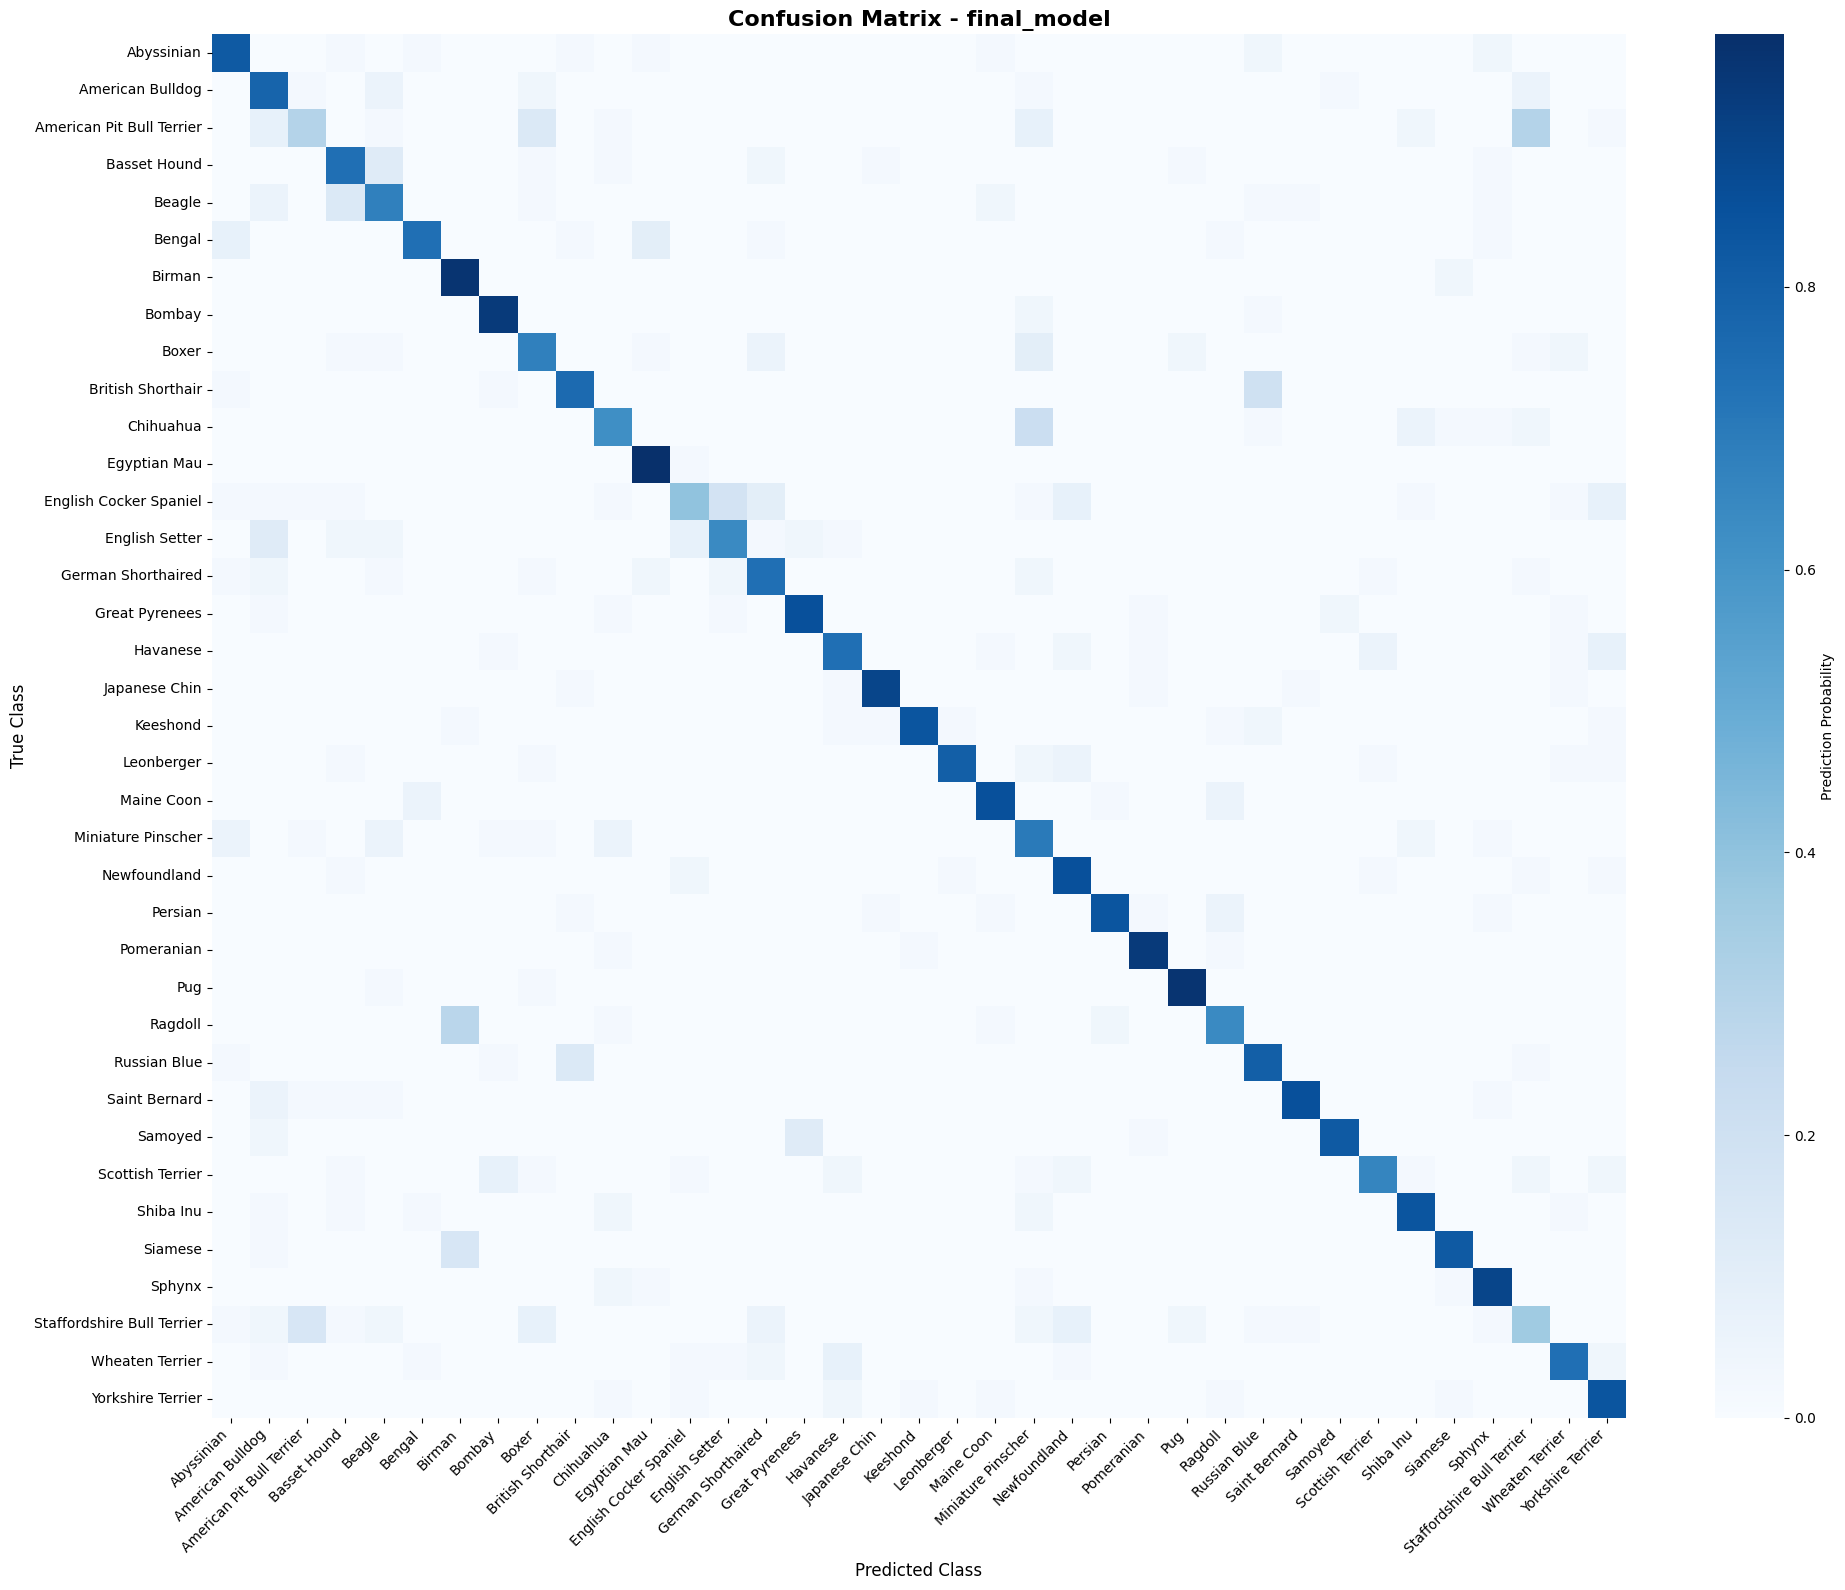

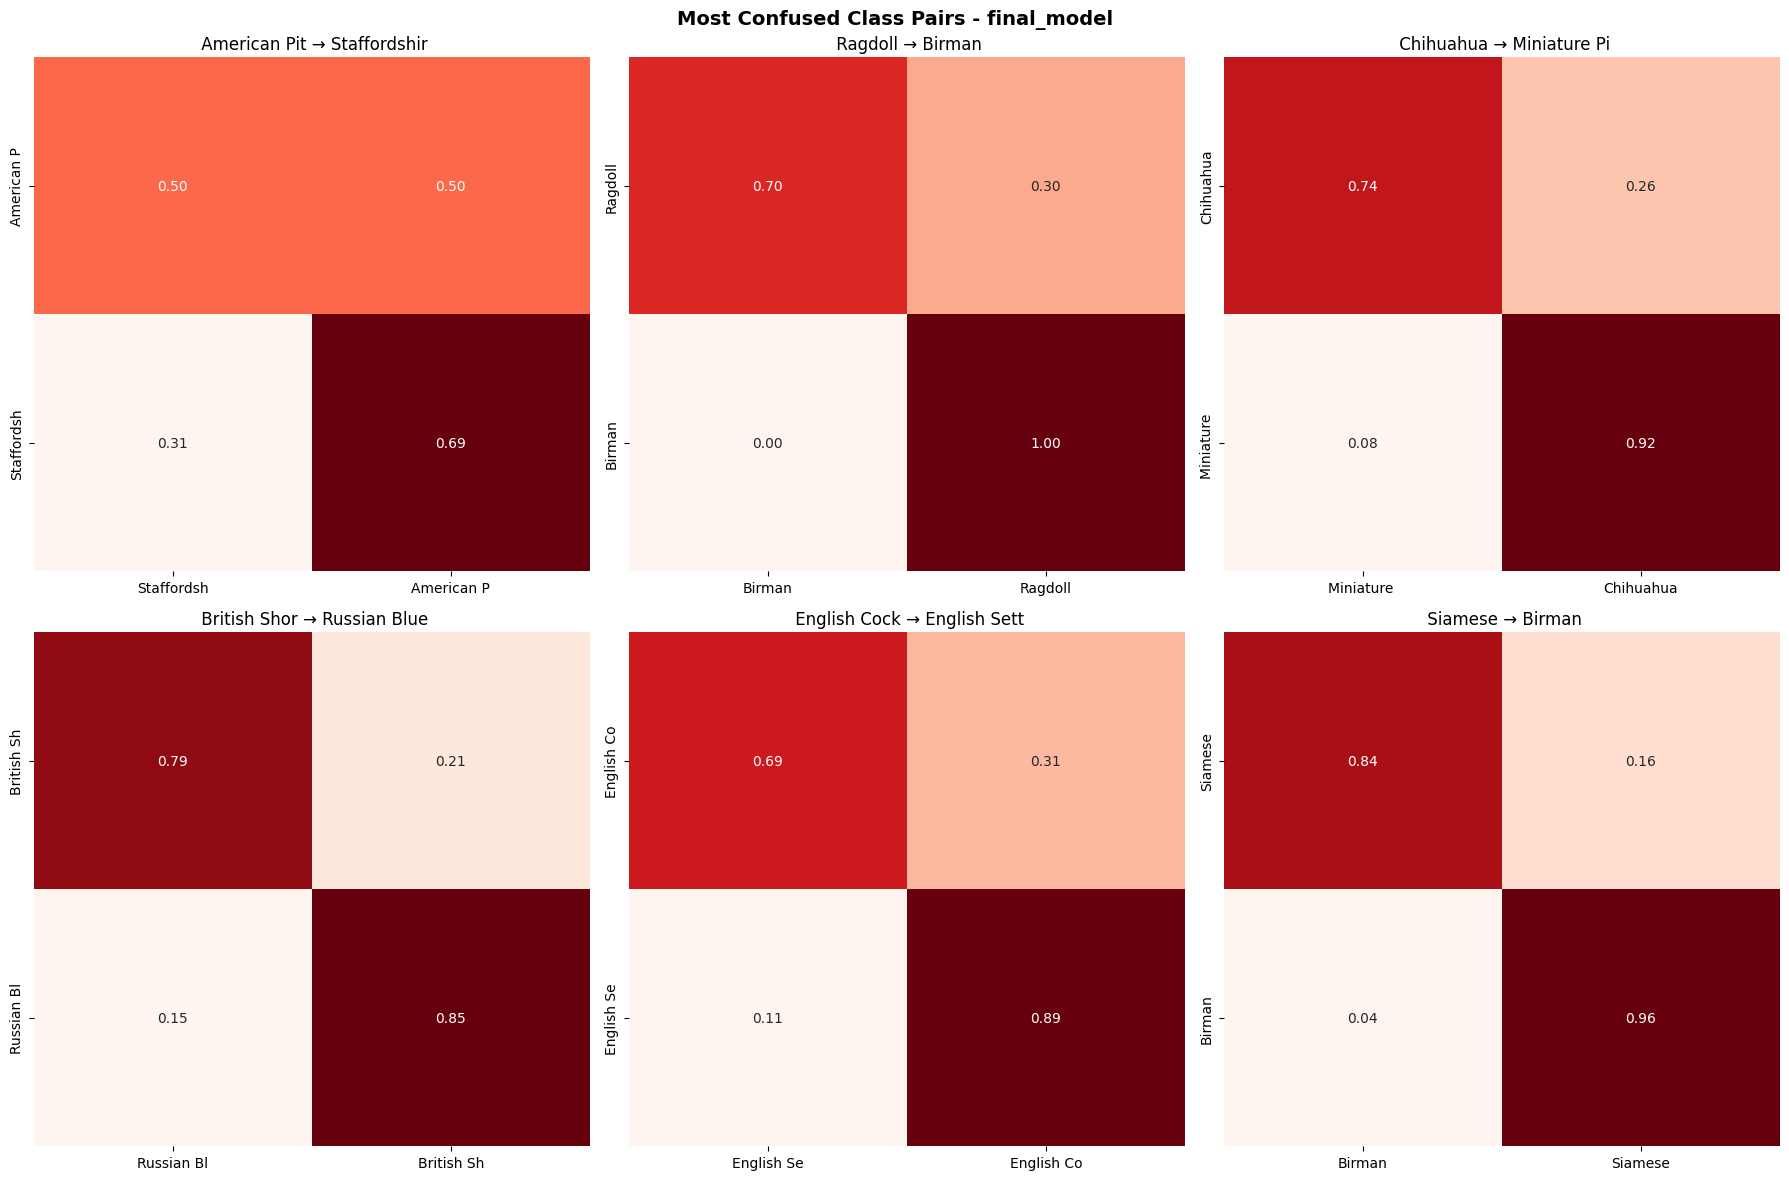

In [66]:
final_model = MobileNet()
analysis_results = analyze_confusion_matrix(
    model=final_model,
    model_name='final_model',
    test_loader=test_loader,
    dataset=test_dataset,
    base_path=base_path,
    class_names=build_class_names(test_dataset),
    top_k=5
)


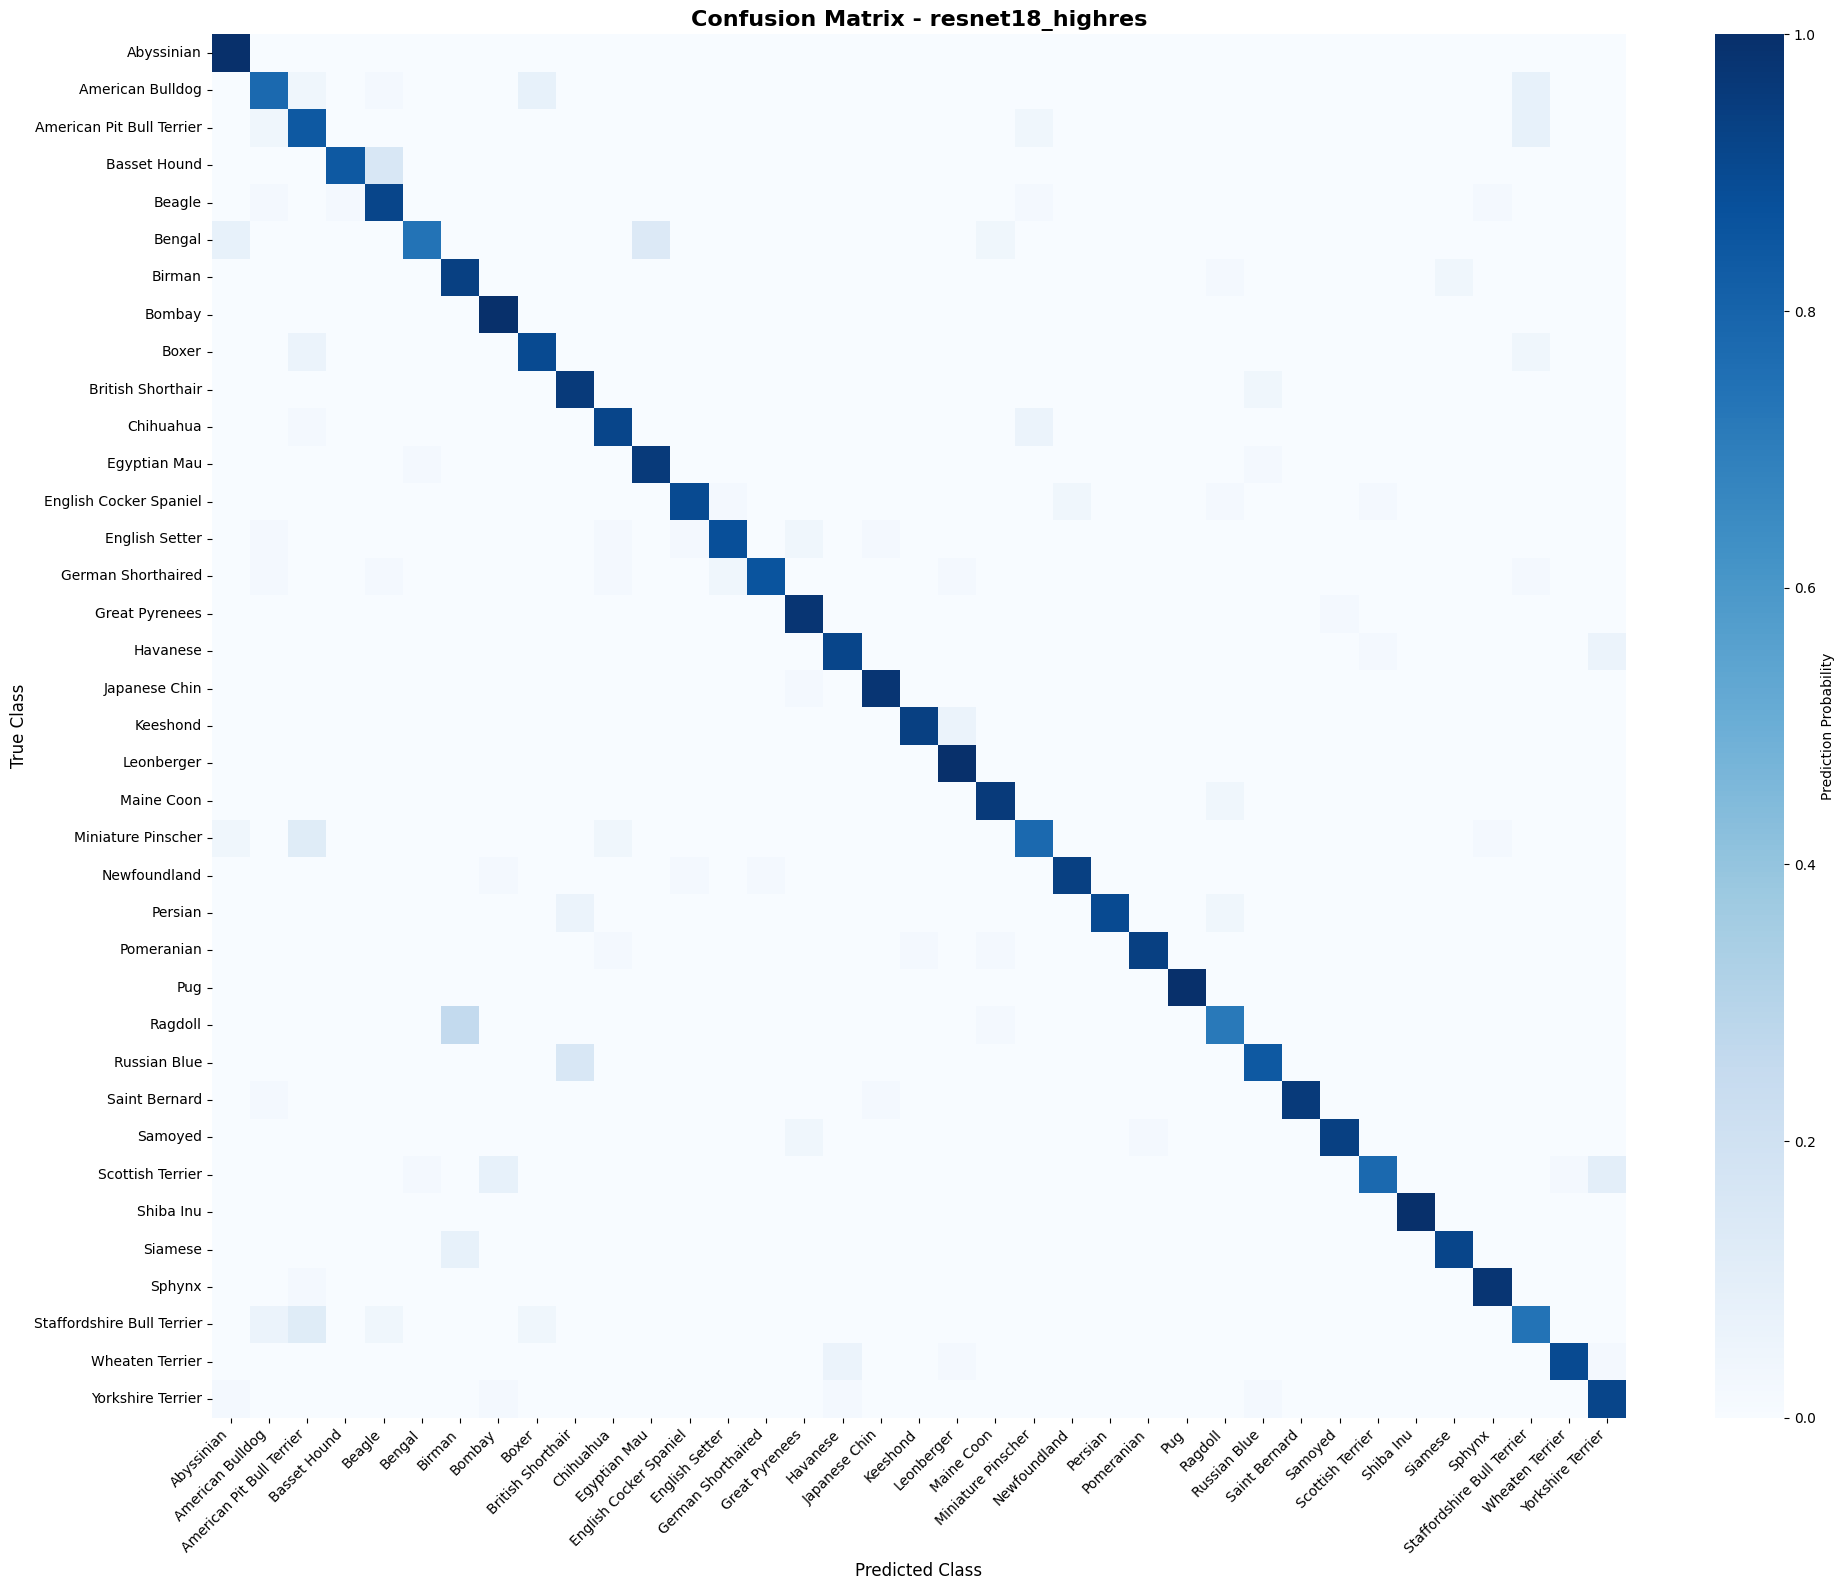

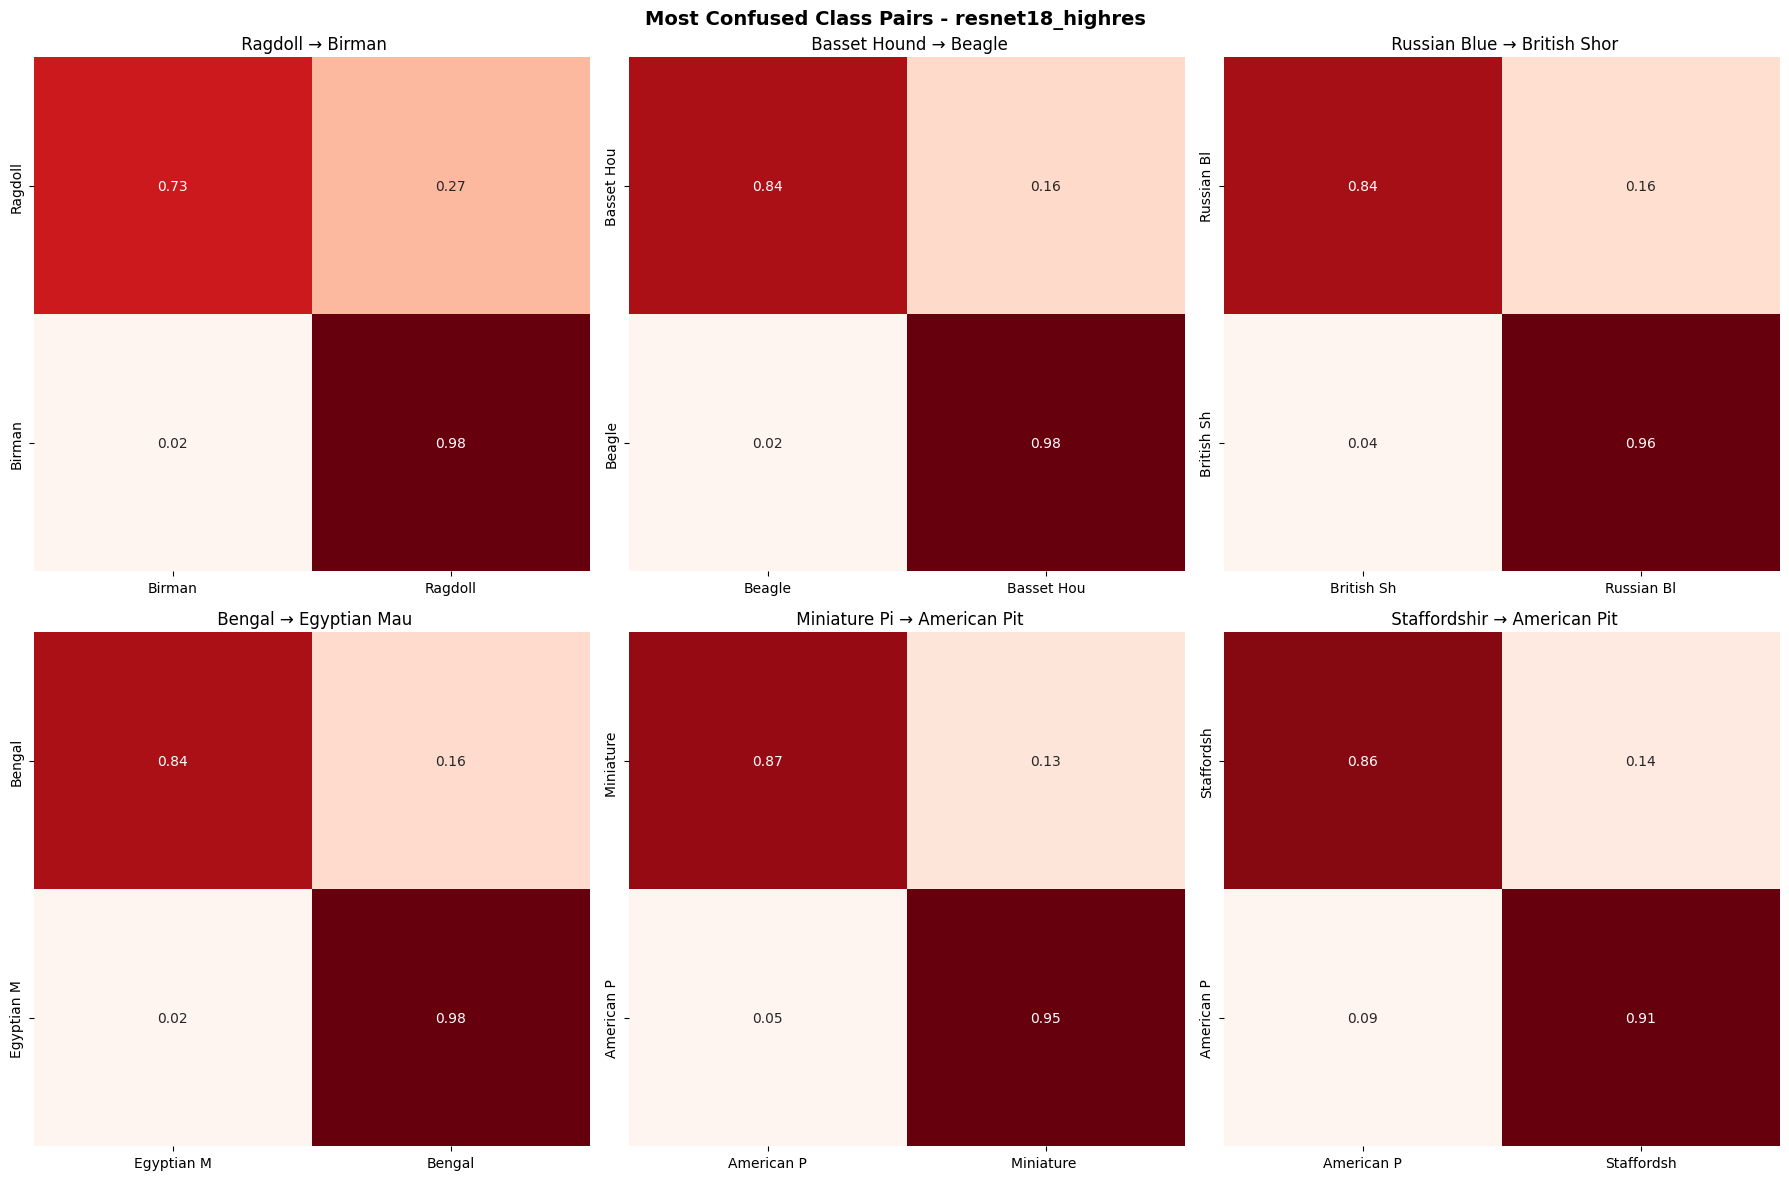

In [67]:
resnet_best = resnet18(weights=None, num_classes=37)
resnet_analysis = analyze_confusion_matrix(
    model=resnet_best,
    model_name='resnet18_highres',
    test_loader=test_loader_highres,  
    dataset=test_dataset_highres,
    base_path=base_path,
    class_names=build_class_names(test_dataset_highres),
    top_k=5
)